## 1. Introduction

### 1.1 Loading Library

In [1]:
import contextily as ctx
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib
import os
import pandas as pd
import numpy as np
from shapely.geometry import MultiPolygon, Polygon
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

os.chdir("C:/Users/ACER/Documents/Term 1-SGDS-UCL/GEOG0115-Introduction to Social Data Science/Data")

### 1.2 Loading Datasets
This section involves loading multiple datasets related to UK parliamentary constituencies, including demographics, economic indicators, and social statistics, to predict the 2024 general election in England and Wales. Some datasets were manually cleaned within the Excel files. Most of the data based on the 2021 Census data.

In [2]:
constituencies_boundaries = "Westminster_Parliamentary_Constituencies_July_2024_Boundaries_UK_BFC_8322311767861589132/PCON_JULY_2024_UK_BFC.shp"
#source: https://geoportal.statistics.gov.uk/datasets/ons::westminster-parliamentary-constituencies-july-2024-boundaries-uk-bfc-2/about

election_result = pd.read_excel("HoC-GE2024-results-by-constituency.xlsx", skiprows=2)
#note: Last updated on Thursday, 12th September 2024. Data obtained directly from Returning Officers following the election.
#source: https://commonslibrary.parliament.uk/research-briefings/cbp-10009/

pop_age = pd.read_excel("population_by_age.xlsx",sheet_name="Edited Age bands")
#Note: England and Wales data are estimates for June 2022. Northern Ireland data are estimates for June 2021. File format was manually edited for easier merging.
#source:https://commonslibrary.parliament.uk/constituency-statistics-population-by-age/

ethnicity_data = pd.read_excel("ethnicity_census.xlsx",sheet_name="Edited Ethnic groups - detailed")
#Note: Based on the 2021 Census. Edited for easier merging. Main value: percentage of the constituency population for each ethnic group.
#source:https://commonslibrary.parliament.uk/constituency-statistics-ethnicity/

wages_data = pd.read_excel("wages.xlsx",sheet_name="Data")
#note: Gross median weekly wages for full-time employees living in each constituency, as of April 2024.
#source: https://commonslibrary.parliament.uk/constituency-data-wages/

households_data = pd.read_excel("households_census.xlsx",sheet_name="Edited Constituency data")
#note: Shows household composition: one-person, family, or other. Includes households with dependent children, people over 65, and married couples. Census conducted in March 2021 (England, Wales, Northern Ireland) and March 2022 (Scotland). Edited for easier merging.
#source: https://commonslibrary.parliament.uk/constitunecy-data-household-composition-2021-census/

childpoverty_data = pd.read_excel("child_poverty.xlsx",sheet_name="Constituencies")
#note: Calibrated to regional Households Below Average Income (HBAI) statistics. Less reliable due to COVID-19 collection conditions (2020/21 and 2021/22). Main value: percentage of children (0-15) in low-income households.
#source: https://commonslibrary.parliament.uk/constituency-data-child-poverty/

education_qualification_data = pd.read_excel("Qualifications_census.xlsx",sheet_name="Edited_constituencies_final")
#note: Based on the 2021 Census (England, Wales, Northern Ireland) and 2022 Census (Scotland). Edited for easier merging. Main value: percentage of population (16+) with highest education qualification.
#source: https://commonslibrary.parliament.uk/constituency-data-educational-qualifications-2021-census/

houseprice_data = pd.read_excel("house-prices.xlsx",sheet_name="Constituency data")
#note: Data from March 2024. Includes median house price and percentage change compared to the previous year.
#source: https://commonslibrary.parliament.uk/constituency-data-house-prices/

tenure_data = pd.read_excel("tenure_census.xlsx",sheet_name="Edited_Constituencies")
#note: Census conducted in March 2021 (England, Wales, Northern Ireland) and March 2022 (Scotland). Edited for merging. Main value: percentage of population by housing tenure groups.
#source: https://commonslibrary.parliament.uk/constituency-data-housing-tenure/

unemployment_benefits_claim_data = pd.read_excel("claimant_count.xlsx",sheet_name="Constituencies")
#note: Data represents the percentage of people (16-64) claiming unemployment benefits, as of November 2024.
#source: https://commonslibrary.parliament.uk/constituency-data-people-claiming-unemployment-benefits/

sexual_orientation_data = pd.read_excel("lgbt_census.xlsx",sheet_name="Edited Sexual orientation")
#note: Based on the 2021 Census (England, Wales, Northern Ireland) and 2022 Census (Scotland). Edited for merging. Main value: percentage of population by sexual orientation groups.
#source: https://commonslibrary.parliament.uk/constituency-data-lgbt-people-2021-census/

religion_data = pd.read_excel("religion_census.xlsx",sheet_name="Edited Constituency")
#note: Census conducted in March 2021 (England, Wales) and March 2022 (Scotland). Edited for merging. Main value: percentage of population by religion groups.
#source: https://commonslibrary.parliament.uk/constituency-data-religion/

disability_data = pd.read_excel("disability_census.xlsx",sheet_name="edited-people")
#note: Census conducted in March 2021 (England, Wales) and March 2022 (Scotland). Edited for merging. Main value: percentage of population by disability status.
#source: https://commonslibrary.parliament.uk/constituency-data-disability/

publicsector_employment_data = pd.read_excel("PublicSectorEmploymentDataDownload.xlsx",sheet_name="Edited-DataByConstituency")
#note: Data from the 2023 Census. Edited for merging.
#source: https://commonslibrary.parliament.uk/constituency-data-public-sector-employment/

campaign_spending_data = pd.read_excel("Campaign Spending Ad Page Data 27-06-2024-04-07-2024.xlsx")
#note: Data from Meta Ad campaign spending (June 27 - July 4, 2024).
#source: trends.whotargets.me/countries

crime_rate_data = pd.read_excel("crime_data.xlsx")
#note: Data as of October 2024.
#source: https://www.ukcrimestats.com/Constituencies/?page=12

deprivation_rate_data = pd.read_excel("deprivation.xlsx",sheet_name="Data_constituencies")
# Note: The latest statistics were released in 2019, based primarily on data from 2015/16.
# The proportion of LSOAs (small areas) which are classed as highly deprived - in the top 10% most deprived in England
#source: https://commonslibrary.parliament.uk/constituency-data-indices-of-deprivation/

employment_rate_data = pd.read_excel("lmregtabli02october2024.xlsx",sheet_name="Edited-LI02")
# Note: Source: Annual Population Survey July 2023 to June 2024. File format was manually edited for easier merging.
#source: https://www.ons.gov.uk/employmentandlabourmarket/peopleinwork/employmentandemployeetypes/datasets/li02regionallabourmarketlocalindicatorsforparliamentaryconstituencies

### 1.3 Merging Data

In [3]:
election_result['turnout_rate'] = (election_result['Valid votes'] / election_result['Electorate']) * 100
columns_to_select = [
    "ONS ID", "ONS region ID", "Constituency name", "Region name", "Country name",
    "Constituency type", "Member first name", "Member surname", "Member gender", 
    "Result", "First party", "turnout_rate", "Majority"
]

election_result = election_result[columns_to_select]

# Constituencies Boundaries
gdf = gpd.read_file(constituencies_boundaries)
overall_data = election_result.merge(gdf, left_on='ONS ID', right_on='PCON24CD', how='left')
columns_to_select = [
    "ONS ID", "ONS region ID", "Constituency name", "Region name", "Country name",
    "Constituency type", "Member first name", "Member surname", "Member gender", 
    "Result", "First party", "turnout_rate", "Majority", "geometry"
]
overall_data = overall_data[columns_to_select]

# Population by Age
overall_data = overall_data.merge(pop_age, left_on='ONS ID', right_on='con_code', how='left')

# Ethnicity Data
overall_data = overall_data.merge(ethnicity_data, left_on='ONS ID', right_on='ONSConstID', how='left')

# Wages Data
overall_data = overall_data.merge(wages_data, left_on='ONS ID', right_on='ONSConstID', how='left')

columns_to_select1 = [
    "ONS ID", "ONS region ID", "Constituency name", "Region name", "Country name",
    "Constituency type", "Member first name", "Member surname", "Member gender", 
    "Result", "First party", "turnout_rate", "Majority", "geometry", 
    "0 to 17", "18 to 24", "25 to 34", "35 to 49", "50 to 64", "65 and over",
    "Asian", "Black, African or Caribbean", "Mixed or Multiple ethnic groups", 
    "White", "Constituency", "Total Population"
]
overall_data = overall_data[columns_to_select1]
overall_data.rename(columns={"Constituency": "Constituency_Median_Weekly_Wage"}, inplace=True)

# Household Composition
overall_data = overall_data.merge(households_data, left_on='ONS ID', right_on='ONSConstID', how='left')
columns_to_select2 = [
    "ONS ID", "ONS region ID", "Constituency name", "Region name", "Country name",
    "Constituency type", "Member first name", "Member surname", "Member gender", 
    "Result", "First party", "turnout_rate", "Majority", "geometry", 
    "0 to 17", "18 to 24", "25 to 34", "35 to 49", "50 to 64", "65 and over",
    "Asian", "Black, African or Caribbean", "Mixed or Multiple ethnic groups", 
    "White", "Constituency_Median_Weekly_Wage", "One-person households", 
    "Families with dependent children", "Other single-family households", "Other household types" , "Total Population"
]
overall_data = overall_data[columns_to_select2]

# Child Poverty Data
childpoverty_data_filtered = childpoverty_data[childpoverty_data["Year"] == "2022/23"]
overall_data = overall_data.merge(childpoverty_data_filtered, left_on='ONS ID', right_on='ONSConstID', how='left')
columns_to_select3 = [
    "ONS ID", "ONS region ID", "Constituency name", "Region name", "Country name",
    "Constituency type", "Member first name", "Member surname", "Member gender", 
    "Result", "First party", "turnout_rate", "Majority", "geometry", 
    "0 to 17", "18 to 24", "25 to 34", "35 to 49", "50 to 64", "65 and over",
    "Asian", "Black, African or Caribbean", "Mixed or Multiple ethnic groups", 
    "White", "Constituency_Median_Weekly_Wage", "One-person households", 
    "Families with dependent children", "Other single-family households", 
    "Other household types", "Constituency relative rate", "Total Population"
]
overall_data = overall_data[columns_to_select3]
overall_data.rename(columns={"Constituency relative rate": "Constituency_childrenaged-0-15_poverty"}, inplace=True)

# Education Qualification Data
overall_data = overall_data.merge(education_qualification_data, left_on='ONS ID', right_on='ONSConstID', how='left')


# House Price Data
houseprice_data["DateOfDataset"] = pd.to_datetime(houseprice_data["DateOfDataset"])
house_price_data_filtered = houseprice_data[houseprice_data["DateOfDataset"] == "2024-03-01"]
overall_data = overall_data.merge(house_price_data_filtered, left_on='ONS ID', right_on='ONSConstID', how='left')
columns_to_select4 = [
    "ONS ID", "ONS region ID", "Constituency name", "Region name", "Country name",
    "Constituency type", "Member first name", "Member surname", "Member gender", 
    "Result", "First party", "turnout_rate", "Majority", "geometry", 
    "0 to 17", "18 to 24", "25 to 34", "35 to 49", "50 to 64", "65 and over",
    "Asian", "Black, African or Caribbean", "Mixed or Multiple ethnic groups", 
    "White", "Constituency_Median_Weekly_Wage", "One-person households", 
    "Families with dependent children", "Other single-family households", 
    "Other household types", "Constituency_childrenaged-0-15_poverty", "No qualifications",
    "1 or more GCSEs", "Apprenticeship", "2 or more A levels", "Higher education qualifications", "Other qualifications",
    "HouseConstMedianPrice", "ConstPercentChangeOneYr", "Total Population"
]

overall_data = overall_data[columns_to_select4]
overall_data.rename(columns={"HouseConstMedianPrice": "House_Const_Median_Price",
                          "ConstPercentChangeOneYr": "House_Const_Percent_ChangeOneYr"}, inplace=True)

# Tenure Data
overall_data = overall_data.merge(tenure_data, left_on='ONS ID', right_on='ONSConstID', how='left')

# Unemployment Benefits Claims
unemployment_benefits_claim_data["Month"] = pd.to_datetime(unemployment_benefits_claim_data["Month"])
unemployment_benefits_claim_data_filtered = unemployment_benefits_claim_data[unemployment_benefits_claim_data["Month"] == "2024-11-01"]
overall_data = overall_data.merge(unemployment_benefits_claim_data_filtered, left_on='ONS ID', right_on='ONSConstID', how='left')
columns_to_select5 = [
    "ONS ID", "ONS region ID", "Constituency name", "Region name", "Country name",
    "Constituency type", "Member first name", "Member surname", "Member gender", 
    "Result", "First party", "turnout_rate", "Majority", "geometry", 
    "0 to 17", "18 to 24", "25 to 34", "35 to 49", "50 to 64", "65 and over",
    "Asian", "Black, African or Caribbean", "Mixed or Multiple ethnic groups", 
    "White", "Constituency_Median_Weekly_Wage", "One-person households", 
    "Families with dependent children", "Other single-family households", 
    "Other household types", "Constituency_childrenaged-0-15_poverty", "No qualifications",
    "1 or more GCSEs", "Apprenticeship", "2 or more A levels", "Higher education qualifications", "Other qualifications",
    "House_Const_Median_Price", "House_Const_Percent_ChangeOneYr", "Owns outright", "Owns with a mortgage or loan",
    "Shared ownership", "All social landlords", "Private landlord or letting agency", "Other private rented", "Lives rent free", "Constituency rate", "Total Population"
]
overall_data = overall_data[columns_to_select5]
overall_data.rename(columns={"Constituency rate": "Constituency_Unemployment_Benefits_Claim_Percentage"}, inplace=True)

# Sexual Orientation Data
overall_data = overall_data.merge(sexual_orientation_data, left_on='ONS ID', right_on='ONSConstID', how='left')

# Religion Data
overall_data = overall_data.merge(religion_data, left_on='ONS ID', right_on='ONSConstID', how='left')

#Disability Data
overall_data = overall_data.merge(disability_data, left_on='ONS ID', right_on='ONSConstID', how='left')

#  Public Sector Employment Data
overall_data = overall_data.merge(publicsector_employment_data, left_on='ONS ID', right_on='NewConstituencyCode', how='left')
columns_to_select6 = [
    "ONS ID", "ONS region ID", "Constituency name", "Region name", "Country name",
    "Constituency type", "Member first name", "Member surname", "Member gender", 
    "Result", "First party", "turnout_rate", "Majority", "geometry", 
    "0 to 17", "18 to 24", "25 to 34", "35 to 49", "50 to 64", "65 and over",
    "Asian", "Black, African or Caribbean", "Mixed or Multiple ethnic groups", 
    "White", "Constituency_Median_Weekly_Wage", "One-person households", 
    "Families with dependent children", "Other single-family households", 
    "Other household types", "Constituency_childrenaged-0-15_poverty", "No qualifications",
    "1 or more GCSEs", "Apprenticeship", "2 or more A levels", "Higher education qualifications", "Other qualifications",
    "House_Const_Median_Price", "House_Const_Percent_ChangeOneYr", "Owns outright", "Owns with a mortgage or loan",
    "Shared ownership", "All social landlords", "Private landlord or letting agency", "Other private rented", "Lives rent free", 
    "Constituency_Unemployment_Benefits_Claim_Percentage", "Straight or Heterosexual",
    "LGB+ sexual orientations", "Christian", "Buddhist", "Hindu", "Jewish", "Muslim", "Sikh", "Other religion", "No religion",
    "Disabled", "Non-Disabled","PctPublicSectorEmployees", "Total Population"
]
overall_data = overall_data[columns_to_select6]

#  Campaign Spending
overall_data = overall_data.merge(campaign_spending_data, left_on='ONS ID', right_on='ONSConstID', how='left')

# Crime Rate Data
overall_data = overall_data.merge(crime_rate_data, left_on='ONS ID', right_on='ONSConstID', how='left')
columns_to_select7 = [
    "ONS ID", "ONS region ID", "Constituency name", "Region name", "Country name",
    "Constituency type", "Member first name", "Member surname", "Member gender", 
    "Result", "First party", "turnout_rate", "Majority", "geometry", 
    "0 to 17", "18 to 24", "25 to 34", "35 to 49", "50 to 64", "65 and over",
    "Asian", "Black, African or Caribbean", "Mixed or Multiple ethnic groups", 
    "White", "Constituency_Median_Weekly_Wage", "One-person households", 
    "Families with dependent children", "Other single-family households", 
    "Other household types", "Constituency_childrenaged-0-15_poverty", "No qualifications",
    "1 or more GCSEs", "Apprenticeship", "2 or more A levels", "Higher education qualifications", "Other qualifications",
    "House_Const_Median_Price", "House_Const_Percent_ChangeOneYr", "Owns outright", "Owns with a mortgage or loan",
    "Shared ownership", "All social landlords", "Private landlord or letting agency", "Other private rented", "Lives rent free", 
    "Constituency_Unemployment_Benefits_Claim_Percentage", "Straight or Heterosexual",
    "LGB+ sexual orientations", "Christian", "Buddhist", "Hindu", "Jewish", "Muslim", "Sikh", "Other religion", "No religion",
    "Disabled", "Non-Disabled","PctPublicSectorEmployees","Top spending page amount", "Page associated party", "Crime per Pop", "Total Population"
]
overall_data = overall_data[columns_to_select7]

# Deprivation Data
overall_data = overall_data.merge(deprivation_rate_data, left_on='ONS ID', right_on='ONSConstID', how='left')
columns_to_select8 = [
    "ONS ID", "ONS region ID", "Constituency name", "Region name", "Country name",
    "Constituency type", "Member first name", "Member surname", "Member gender", 
    "Result", "First party", "turnout_rate", "Majority", "geometry", 
    "0 to 17", "18 to 24", "25 to 34", "35 to 49", "50 to 64", "65 and over",
    "Asian", "Black, African or Caribbean", "Mixed or Multiple ethnic groups", 
    "White", "Constituency_Median_Weekly_Wage", "One-person households", 
    "Families with dependent children", "Other single-family households", 
    "Other household types", "Constituency_childrenaged-0-15_poverty", "No qualifications",
    "1 or more GCSEs", "Apprenticeship", "2 or more A levels", "Higher education qualifications", "Other qualifications",
    "House_Const_Median_Price", "House_Const_Percent_ChangeOneYr", "Owns outright", "Owns with a mortgage or loan",
    "Shared ownership", "All social landlords", "Private landlord or letting agency", "Other private rented", "Lives rent free", 
    "Constituency_Unemployment_Benefits_Claim_Percentage", "Straight or Heterosexual",
    "LGB+ sexual orientations", "Christian", "Buddhist", "Hindu", "Jewish", "Muslim", "Sikh", "Other religion", "No religion",
    "Disabled", "Non-Disabled","PctPublicSectorEmployees","Top spending page amount", "Page associated party", "Crime per Pop",
    "Total Population", "Share of LSOAs in most deprived decile"
]
overall_data = overall_data[columns_to_select8]


employment_rate_data
# Employment Rate Data
overall_data = overall_data.merge(employment_rate_data, left_on='ONS ID', right_on='Geography Code', how='left')
columns_to_select9 = [
    "ONS ID", "ONS region ID", "Constituency name", "Region name", "Country name",
    "Constituency type", "Member first name", "Member surname", "Member gender", 
    "Result", "First party", "turnout_rate", "Majority", "geometry", 
    "0 to 17", "18 to 24", "25 to 34", "35 to 49", "50 to 64", "65 and over",
    "Asian", "Black, African or Caribbean", "Mixed or Multiple ethnic groups", 
    "White", "Constituency_Median_Weekly_Wage", "One-person households", 
    "Families with dependent children", "Other single-family households", 
    "Other household types", "Constituency_childrenaged-0-15_poverty", "No qualifications",
    "1 or more GCSEs", "Apprenticeship", "2 or more A levels", "Higher education qualifications", "Other qualifications",
    "House_Const_Median_Price", "House_Const_Percent_ChangeOneYr", "Owns outright", "Owns with a mortgage or loan",
    "Shared ownership", "All social landlords", "Private landlord or letting agency", "Other private rented", "Lives rent free", 
    "Constituency_Unemployment_Benefits_Claim_Percentage", "Straight or Heterosexual",
    "LGB+ sexual orientations", "Christian", "Buddhist", "Hindu", "Jewish", "Muslim", "Sikh", "Other religion", "No religion",
    "Disabled", "Non-Disabled","PctPublicSectorEmployees","Top spending page amount", "Page associated party", "Crime per Pop",
    "Total Population", "Share of LSOAs in most deprived decile", "Employment rate age 16 to 64 July 2023 to June 2024 %"
]
overall_data = overall_data[columns_to_select9]

# Renaming Columns
overall_data.rename(columns={"Member first name": "Elected Member First Name",
                            "Member surname": "Elected Member Surname",
                            "Member gender": "Elected Member Gender",
                            "Result": "Election Result",
                            "First party": "Elected Party",
                            "0 to 17": "age_pct(0-17)",
                            "18 to 24": "age_pct(18-24)",
                            "25 to 34": "age_pct(25-34)",
                            "35 to 49": "age_pct(35-49)",
                            "50 to 64": "age_pct(50-64)",
                            "65 and over": "age_pct(65+)",
                            "Asian": "asian_pop_pct",
                            "Black, African or Caribbean": "black_pop_pct",
                            "Mixed or Multiple ethnic groups": "mixed_pop_pct",
                            "White": "white_pop_pct",
                             "Constituency_Median_Weekly_Wage": "median_weekly_wage",
                            "One-person households": "one-person_households",
                            "Families with dependent children": "families_children_households",
                            "Other single-family households": "other_single_family_households",
                            "Other household types": "other_households",
                            "Constituency_childrenaged-0-15_poverty": "children_poverty",
                            "No qualifications": "no_qualifications",
                            "1 or more GCSEs": "1 or more GCSEs",
                            "Apprenticeship": "apprenticeship",
                            "2 or more A levels": "2 or more A levels",
                            "Higher education qualifications": "higher_qualifications",
                            "Other qualifications": "other_qualifications",
                            "House_Const_Median_Price": "median_house_price",
                            "House_Const_Percent_ChangeOneYr": "houseprice_change",
                            "Owns outright":"house_owns outright",
                            "Owns with a mortgage or loan":"house_owns_mortgage",
                            "Shared ownership":"house_shared",
                            "All social landlords":"house_social_landlords",
                            "Private landlord or letting agency":"house_private_landlord",
                            "Other private rented":"house_other",
                            "Lives rent free":"house_rent free",
                            "Constituency_Unemployment_Benefits_Claim_Percentage": "unemployment_claim_rate",
                            "Straight or Heterosexual": "straight_pct",
                            "LGB+ sexual orientations": "LGBT+_pct",
                            "Christian": "Christian_pct",
                            "Buddhist": "Buddhist_pct",
                            "Hindu": "Hindu_pct",
                            "Jewish": "Jewish_pct",
                            "Muslim": "Muslim_pct",
                            "Sikh": "Sikh_pct",
                            "Other religion": "other_religion",
                            "No religion": "no_religion",
                            "Disabled": "disabled_pct",
                            "PctPublicSectorEmployees": "public_sector_rate",
                            "Top spending page amount": "top_ad_spending",
                            "Page associated party": "ad_associated_party",
                            "Crime per Pop": "crime_rate",
                            "Non-Disabled": "non-disabled_pct",
                            "Share of LSOAs in most deprived decile": "deprived_pct",
                            "Employment rate age 16 to 64 July 2023 to June 2024 %": "employment_rate"}, inplace=True)

#Calculating Population Density
overall_data = gpd.GeoDataFrame(overall_data, geometry=overall_data['geometry'])
overall_data['geometry'] = overall_data['geometry'].apply(
    lambda geom: MultiPolygon([geom]) if isinstance(geom, Polygon) else geom
)  #source: Chatgpt
overall_data = overall_data.to_crs(epsg=27700) 
overall_data['Area'] = overall_data['geometry'].area / 1e6 
overall_data['population_density'] = overall_data['Total Population'] / overall_data['Area']

#Calculating Youth Population Percentage
overall_data['youth_population'] = overall_data['age_pct(18-24)'] + overall_data['age_pct(25-34)']

newcolumns = [
    "ONS ID", "ONS region ID", "Constituency name", "Region name", "Country name",
    "Constituency type", "Elected Member First Name", "Elected Member Surname",
    "Elected Member Gender", "Election Result", "Elected Party", "turnout_rate", "Majority","youth_population", "white_pop_pct", "median_weekly_wage",
    "families_children_households", "children_poverty", "higher_qualifications",
    "house_owns_mortgage", "unemployment_claim_rate", "straight_pct", "Christian_pct", "non-disabled_pct",
    "public_sector_rate", "top_ad_spending", "ad_associated_party",	"crime_rate", "geometry", "median_house_price", "houseprice_change", 
    "population_density", "deprived_pct","employment_rate"
]

overall_data = overall_data[newcolumns]

#Organizing Column Order
column_order = [
    "ONS ID", "ONS region ID", "Constituency name", "Region name", "Country name",
    "Constituency type", "Elected Member First Name", "Elected Member Surname",
    "Elected Member Gender", "Election Result", "Elected Party", "turnout_rate", "Majority", "top_ad_spending", "ad_associated_party","youth_population", "white_pop_pct", "Christian_pct", 
    "straight_pct", "deprived_pct", "median_weekly_wage", "children_poverty", "crime_rate", "employment_rate", 
     "unemployment_claim_rate", "public_sector_rate", "higher_qualifications", "non-disabled_pct", 
    "families_children_households", "house_owns_mortgage","median_house_price", "houseprice_change", "population_density", "geometry"
]

#Cleaning the party names
overall_data = overall_data[column_order]
overall_data['Elected Party'] = overall_data['Elected Party'].replace({
    "Lab": "Labour Party",
    "Con": "Conservative",
    "RUK" : "Reform UK",
    "LD": "Liberal Democrats",
    "Ind": "Independent",
    "Green": "Green Party",
    "DUP": "Democratic Unionist Party",
    "SDLP": "Social Democratic and Labour Party",
    "PC": "Plaid Cymru",
    "SF": "Sinn Féin",
    "Spk": "Spk",
    "APNI": "Alliance Party of Northern Ireland",
    "TUV": "Traditional Unionist Voice",
    "UUP": "Ulster Unionist Party"})

#code source: (OpenAI, 2024l)

## 2. Data Wrangling

### 2.1 Data Filtering and Cleaning
This code identifies unique countries in the dataset and addresses missing or invalid values in the 'Country name' column. It filters the dataset to include only entries for England and Wales, excluding Scotland and Northern Ireland due to missing constituency data for these two countries. Additionally, the code cleans and converts the 'houseprice_change' column to ensure it is in numeric format, preparing it for further analysis.

In [4]:
unique_countries = overall_data['Country name'].unique()
print(unique_countries)
na_count = overall_data['Country name'].isna().sum()
print(f"Number of NaN values in 'Country name': {na_count}")
blank_count = (overall_data['Country name'] == '').sum()
print(f"Number of blank values in 'Country name': {blank_count}")

overall_data1 = overall_data[overall_data['Country name'].isin(['Wales', 'England'])]
overall_data1['houseprice_change'] = overall_data1['houseprice_change'].replace(['-', 'N/A', '', 'nan'], np.nan)
overall_data1['houseprice_change'] = pd.to_numeric(overall_data1['houseprice_change'], errors='coerce')
overall_data1.info()

#code source: (OpenAI, 2024e)

['Wales' 'Scotland' 'England' 'Northern Ireland']
Number of NaN values in 'Country name': 0
Number of blank values in 'Country name': 0
<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 575 entries, 0 to 649
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   ONS ID                        575 non-null    object  
 1   ONS region ID                 575 non-null    object  
 2   Constituency name             575 non-null    object  
 3   Region name                   575 non-null    object  
 4   Country name                  575 non-null    object  
 5   Constituency type             575 non-null    object  
 6   Elected Member First Name     575 non-null    object  
 7   Elected Member Surname        575 non-null    object  
 8   Elected Member Gender         575 non-null    object  
 9   Election Result               575 non-null    object  
 10  Elected Party                 5

C:\Users\ACER\AppData\Local\Temp\ipykernel_12868\3163801087.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  overall_data1['houseprice_change'] = overall_data1['houseprice_change'].replace(['-', 'N/A', '', 'nan'], np.nan)
C:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


From the dataset, we observe that most columns do not have missing values, except for top_ad_spending, ad_associated_party, deprived_pct, and crime_rate, which contain several missing values. These missing values will need to be imputed to enhance the performance of the machine learning models. The imputation process will be discussed later.

In [5]:
missing_count = overall_data1.isna().sum()
print("Count of missing values")
print(missing_count)

Count of missing values
ONS ID                           0
ONS region ID                    0
Constituency name                0
Region name                      0
Country name                     0
Constituency type                0
Elected Member First Name        0
Elected Member Surname           0
Elected Member Gender            0
Election Result                  0
Elected Party                    0
turnout_rate                     0
Majority                         0
top_ad_spending                 83
ad_associated_party             83
youth_population                 0
white_pop_pct                    0
Christian_pct                    0
straight_pct                     0
deprived_pct                    32
median_weekly_wage               0
children_poverty                 0
crime_rate                       3
employment_rate                  0
unemployment_claim_rate          0
public_sector_rate               0
higher_qualifications            0
non-disabled_pct               

## 3. Exploratory Data Analysis

### 3.1 Summary Statistics

In [6]:
overall_data1.describe()

,turnout_rate,Majority,top_ad_spending,youth_population,white_pop_pct,Christian_pct,straight_pct,deprived_pct,median_weekly_wage,children_poverty,...,employment_rate,unemployment_claim_rate,public_sector_rate,higher_qualifications,non-disabled_pct,families_children_households,house_owns_mortgage,median_house_price,houseprice_change,population_density
count,575.000000,575.000000,492.000000,575.000000,575.000000,575.000000,575.000000,543.000000,575.000000,575.000000,...,575.000000,575.000000,575.000000,575.000000,575.000000,575.000000,575.000000,5.750000e+02,575.000000,575.000000
mean,59.836378,7157.514783,680.484939,0.213839,0.831181,0.466029,0.895262,0.095471,733.716000,0.191892,...,75.836322,0.040727,0.183704,0.335714,0.823159,0.283889,0.289280,3.115577e+05,-0.021724,2309.427081
std,7.031757,4878.712786,830.022342,0.063510,0.173020,0.077803,0.026302,0.138637,92.009845,0.088097,...,7.409930,0.020429,0.084346,0.090202,0.032221,0.045975,0.052975,1.446008e+05,0.036007,2950.224182
min,39.985952,15.000000,1.260000,0.133047,0.201078,0.148977,0.769909,0.000000,570.400000,0.047105,...,49.832308,0.014000,0.040000,0.180848,0.741657,0.156391,0.106925,9.000000e+04,-0.142832,29.691773
25%,54.692110,3371.000000,182.547500,0.174240,0.771667,0.425766,0.887764,0.000000,666.300000,0.126383,...,71.359865,0.026000,0.120000,0.270411,0.800381,0.252825,0.257994,2.050000e+05,-0.044118,313.477594
50%,60.437340,6357.000000,374.225000,0.196971,0.902626,0.477453,0.903785,0.033333,715.400000,0.180621,...,76.637813,0.034000,0.160000,0.320487,0.823725,0.279690,0.291616,2.800000e+05,-0.025000,1096.737310
75%,65.522518,10198.000000,895.750000,0.224981,0.958231,0.510072,0.912963,0.139141,790.450000,0.230151,...,80.862273,0.049000,0.240000,0.376155,0.848202,0.310772,0.328517,3.790000e+05,0.000000,3345.108111
max,75.213865,21983.000000,9156.930000,0.593341,0.981978,0.688160,0.933341,0.837209,1067.900000,0.577362,...,95.004307,0.162000,0.570000,0.652212,0.894230,0.479875,0.398083,1.195000e+06,0.145238,19505.768218


### 3.2 Choropleth Map

From the choropleth map, we can observe several patterns. The variables for deprivation percentage and child poverty percentage are mostly concentrated around the Midlands region.

In London, there is a high concentration of youth population, a higher percentage of individuals with higher qualifications, a higher median weekly wage, and a higher rate of unemployment benefit claims. Additionally, London exhibits high median house prices, high crime rates, and, naturally, a high population density.

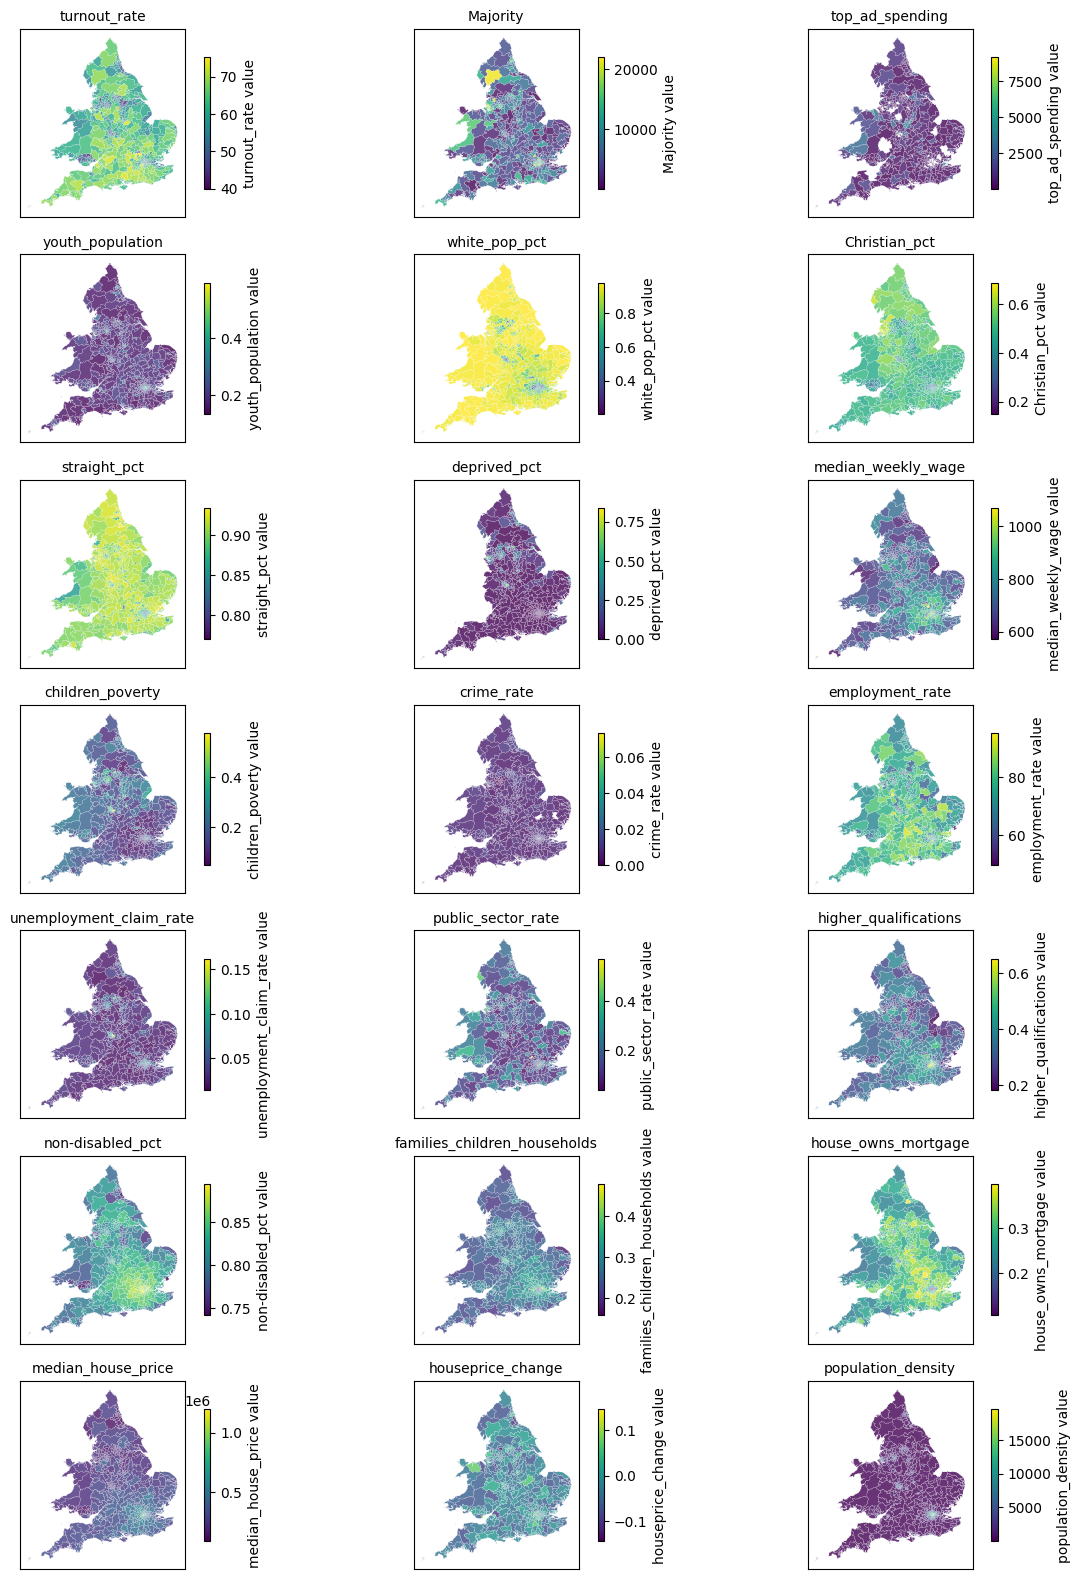

In [160]:
#Warning: This code will take a really long time to load
numerical_columns = overall_data1.select_dtypes(include=[np.number]).columns
nrows = 7
ncols = 3


fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 20))  
axes = axes.flatten()  
for i, column in enumerate(numerical_columns[:len(axes)]):  
    ax = axes[i]
    
    overall_data1.plot(
        ax=ax,
        column=column,
        alpha=0.8,
        linewidth=0.1,
        edgecolor='w',
        legend=True,
        legend_kwds={'label': f"{column} value", 'orientation': "vertical", 'shrink': 0.7},
    )
    
    ax.set_title(f"{column}", fontsize=10)
    ax.set_xticks([])  
    ax.set_xticklabels([]) 
    ax.set_yticks([])
    ax.set_yticklabels([])

# Remove unused axes
for j in range(len(numerical_columns), len(axes)):
    fig.delaxes(axes[j])


plt.subplots_adjust(wspace=0.05, hspace=0.2) 
output_path = "choropleth_maps.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')

plt.show()

#code source: (Law et al., 2024a; OpenAI, 2024d)

### 3.3 Data Distribution

Most of the data is skewed; however, since normality is not a requirement for machine learning models, I have decided not to transform the independent variables.

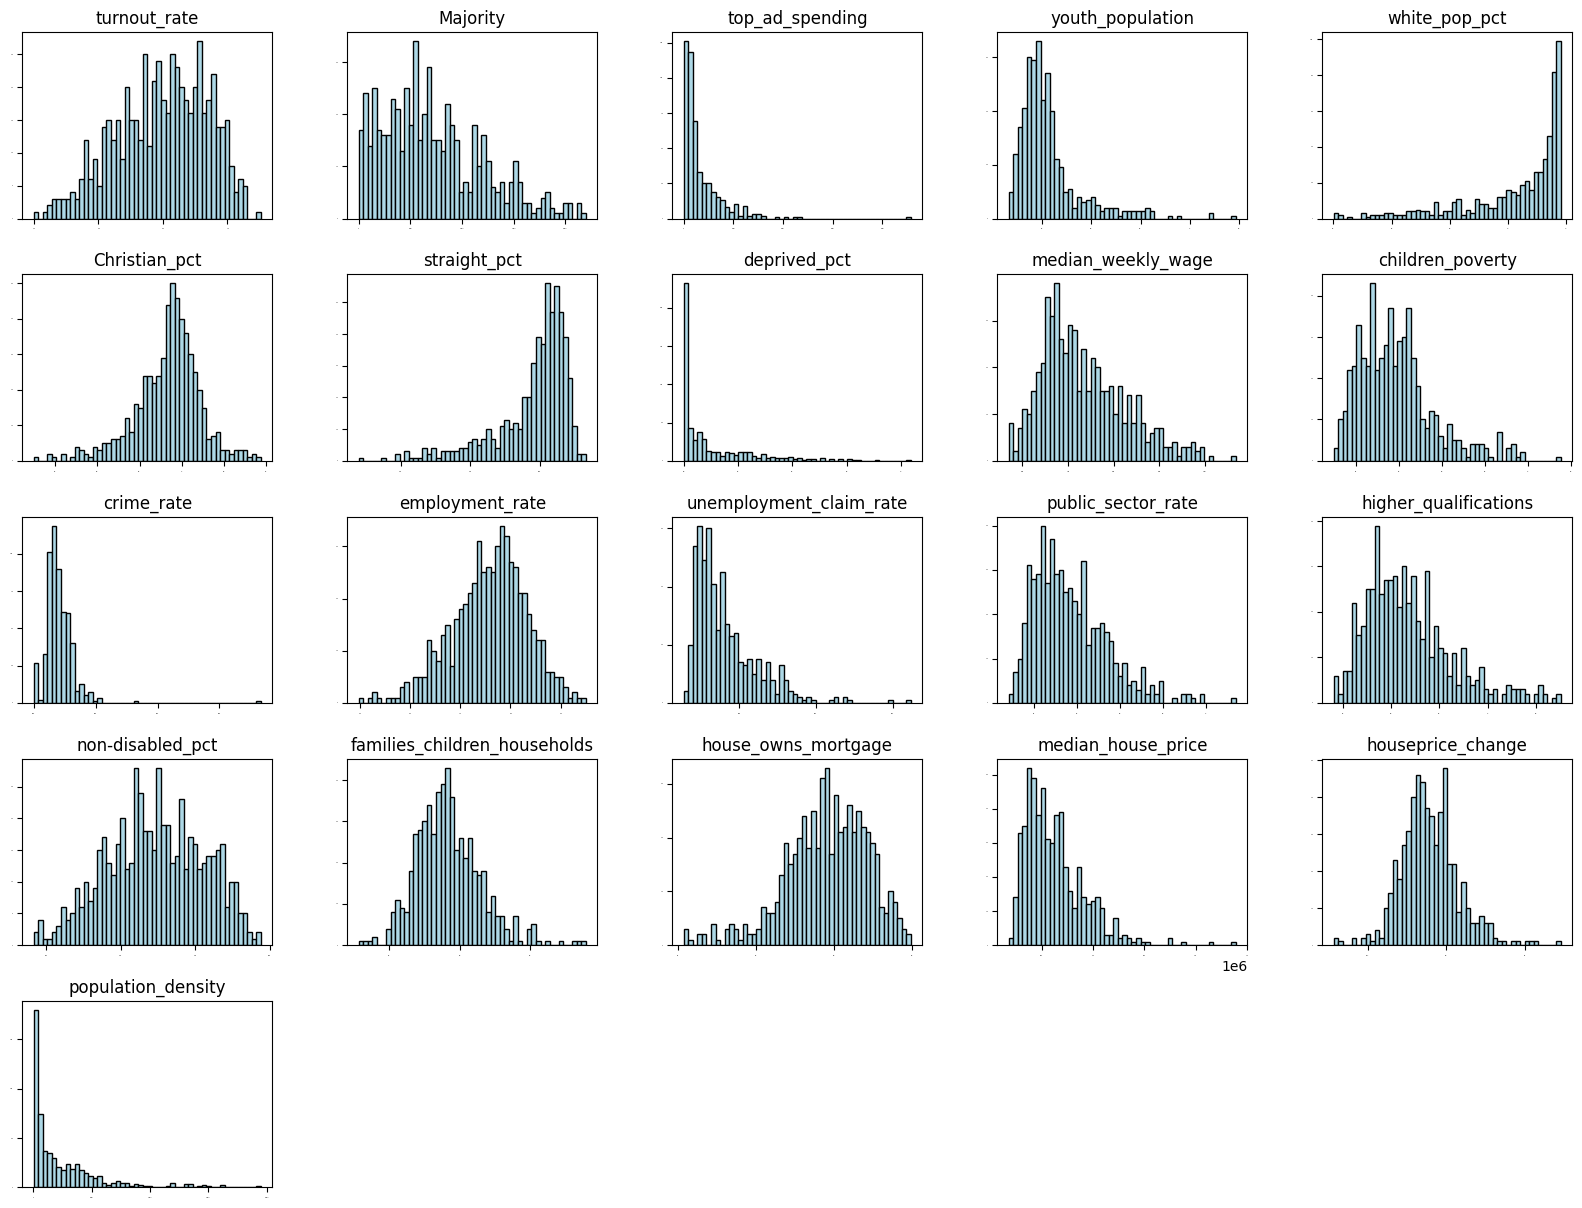

In [7]:
overall_data1.hist(bins=50, figsize=(20,15),  color='#add8e6', edgecolor='black', xlabelsize=0, ylabelsize=0, grid=False) 
plt.show()

In [8]:
categorical_data = overall_data1.select_dtypes(include=[object])
categorical_data.columns

Index(['ONS ID', 'ONS region ID', 'Constituency name', 'Region name',
       'Country name', 'Constituency type', 'Elected Member First Name',
       'Elected Member Surname', 'Elected Member Gender', 'Election Result',
       'Elected Party', 'ad_associated_party'],
      dtype='object')

As the winner of the UK 2024 general election, it is expected that the Labour Party secured the majority of votes. This trend is also reflected in the advertisement performance of each party, where the Labour Party has the largest number of constituencies with higher investment compared to other parties. This uneven distribution may contribute to lower accuracy in machine learning performance, a topic that will be discussed in later sections.

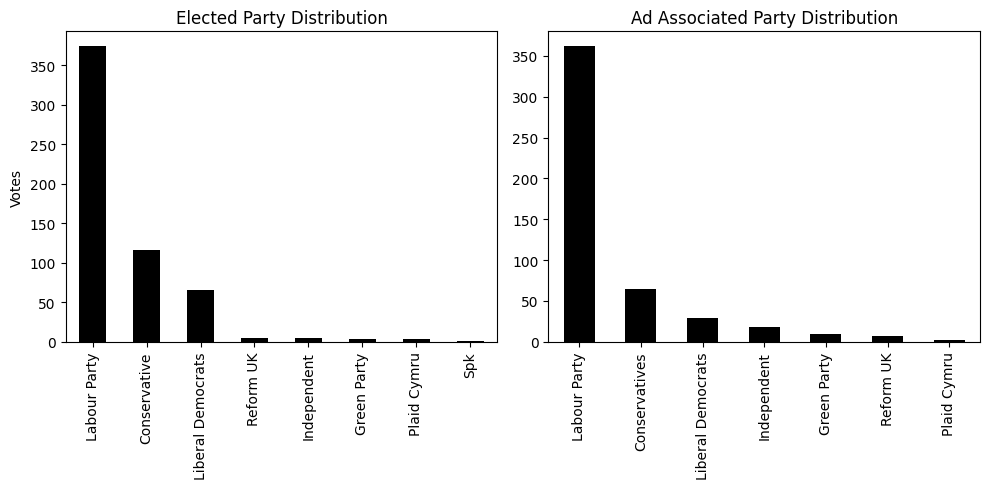

In [9]:
fig,ax=plt.subplots(1,2,figsize=(10,5))
categorical_data['Elected Party'].value_counts().plot(kind='bar',color='black',ax=ax[0])
ax[0].set_title("Elected Party Distribution")
ax[0].set_xlabel("")
ax[0].set_ylabel("Votes")

categorical_data['ad_associated_party'].value_counts().plot(kind='bar',color='black',ax=ax[1])  # Remove x-axis values
ax[1].set_title("Ad Associated Party Distribution")
ax[1].set_xlabel("")

plt.tight_layout() 
plt.show()

#code source: (Law et al., 2024d; OpenAI, 2024o)

### 3.4 Boxplots

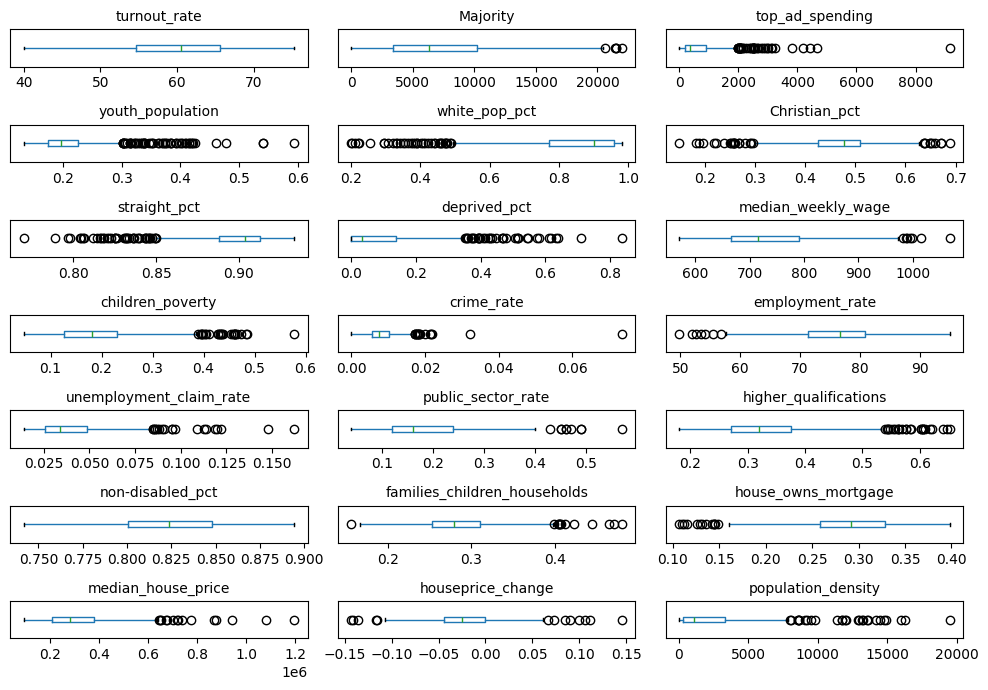

In [10]:
numeric_data = overall_data1.select_dtypes(include=[np.number])
rows, cols = 7, 3
fig, axes = plt.subplots(rows, cols, figsize=(10, 7))
axes = axes.flatten()


for i, column in enumerate(numeric_data.columns):
    numeric_data.boxplot(column=column, ax=axes[i], vert=False)
    axes[i].set_title(column, fontsize=10)
    axes[i].set_yticks([])
    axes[i].grid(False) 


for j in range(len(numeric_data.columns), len(axes)):
    axes[j].axis('off')

plt.tight_layout() 
plt.show()

#code source: (Law et al., 2024c; OpenAI, 2024j)

### 3.5 Correlation Matrix

From the correlation matrix, several interesting patterns emerge. As expected, the deprivation percentage shows a strong positive correlation with the children’s poverty percentage (0.79) and the unemployment benefits claim percentage (0.64). Additionally, the youth population percentage exhibits a strong positive correlation with population density and a moderately high positive correlation with crime rate and unemployment benefits claim rate. Constituencies with a high percentage of the white population show a moderate positive correlation with turnout rate (0.39) and a strong negative correlation with the unemployment benefits claim rate (-0.76), potentially highlighting inequalities that could influence election outcomes. Lastly, turnout rate has a strong negative correlation—averaging around -0.7—with deprivation percentage, children’s poverty percentage, and unemployment benefits claim rate. This pattern suggests that individuals in economically deprived areas may be less inclined to participate in the election.

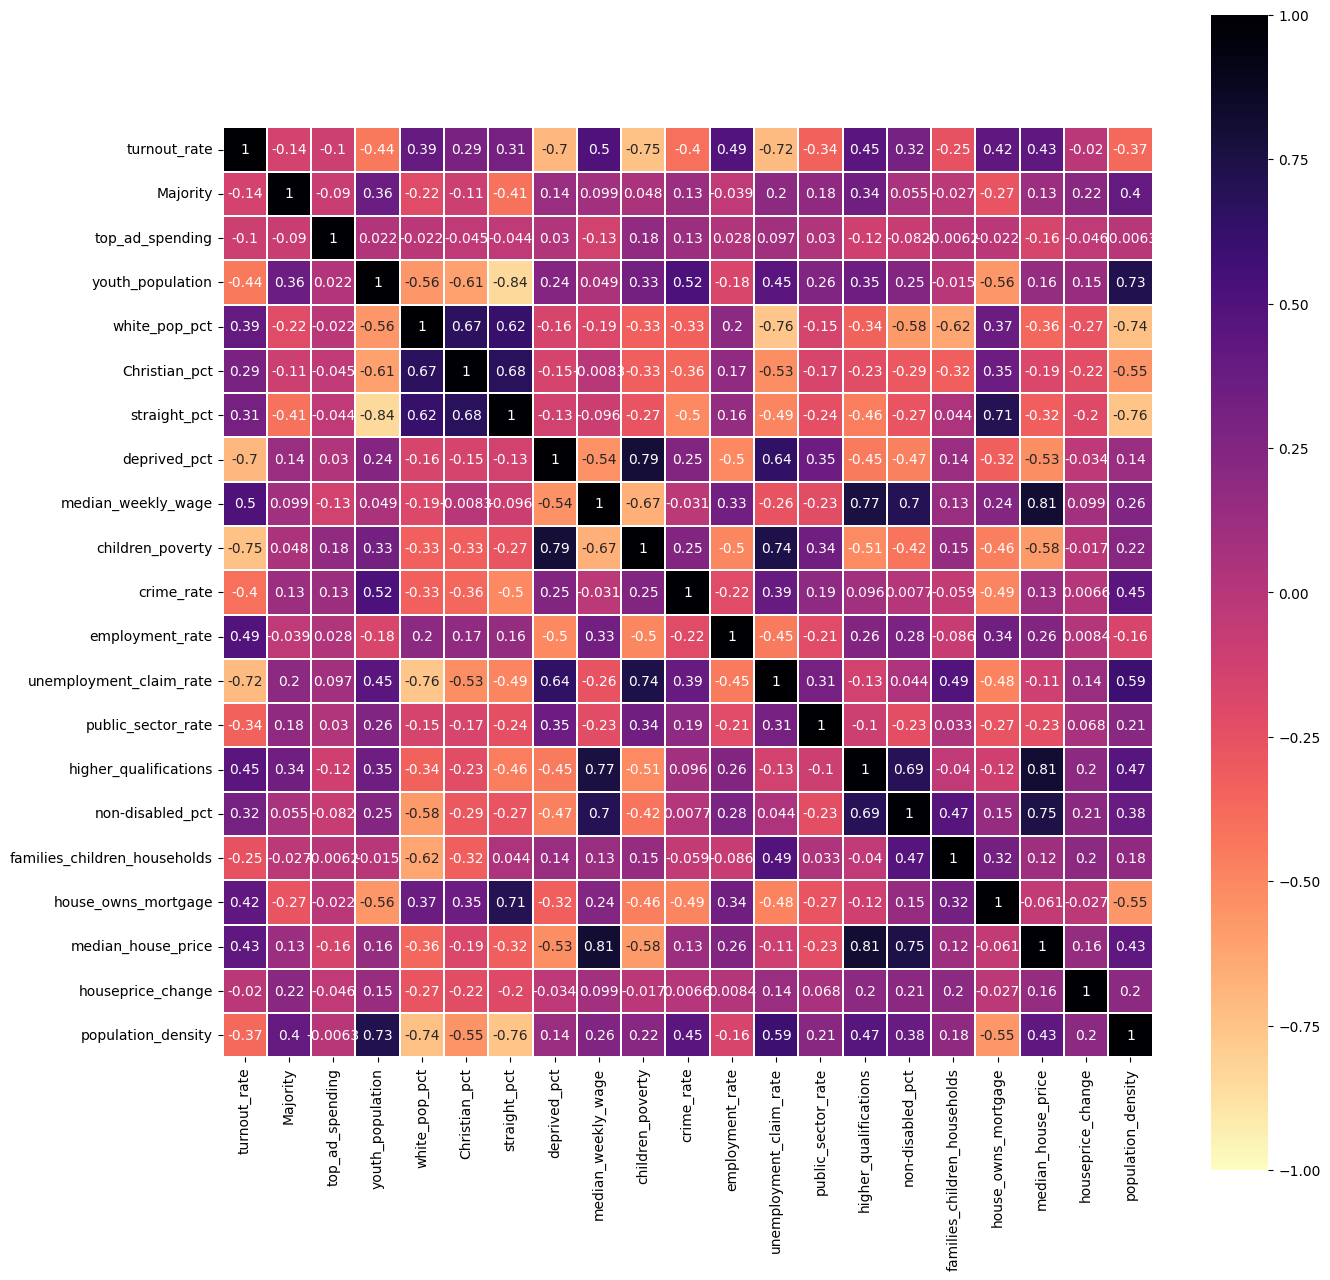

In [11]:
import seaborn as sns
corr = overall_data1[numeric_data.columns].corr()
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr, center=0,cmap=plt.get_cmap('magma_r'),
            square=True, linewidths=.05, annot=True, vmin=-1, vmax=1,ax=ax) 
plt.show()

#code source: (Law et al., 2024d)

## 4. Model Preparation

### 4.1 Splitting Datasets

The data is split into training and testing sets using an 80-20 split (train_size=0.8) and random_state=42 is for reproducibility, so the split will be consistent each time the code runs. Some columns like ONS region ID, ONS ID, and Constituency nameare excluded from the features as they are not directly relevant to the model. The 'Elected Party' column is designated as the target variable (ylabels), representing the party that won in each constituency, which the model aims to predict.

In [12]:
from sklearn.model_selection import train_test_split

X = overall_data1.drop(columns=['ONS region ID', 'ONS ID', 'Constituency name', 
                               'Constituency type','Elected Member First Name', 'Elected Member Surname', 'Elected Member Gender','Election Result',
                            'Country name','geometry','Elected Party','Region name'])
ylabels = overall_data1['Elected Party']

(X_train, X_test, y_train, y_test) = train_test_split(X, ylabels, train_size=0.8, random_state=42)
print (f"X_train has dim of {X_train.shape}")
print (f"y_train has dim of {y_train.shape}")
print (f"X_test has dim of {X_test.shape}")
print (f"y_test has dim of {y_test.shape}")

#code source: (Géron, 2017; Law et al., 2024d; OpenAI, 2024a)

X_train has dim of (460, 22)
y_train has dim of (460,)
X_test has dim of (115, 22)
y_test has dim of (115,)


### 4.2 Imputing Missing Data

Since there are missing values in the columns 'top_ad_spending,' 'ad_associated_party,' 'deprived_pct,' and 'crime_rate,' it is necessary to impute these values to prevent them from negatively impacting the model's performance. Imputation is performed after splitting the data to avoid data leakage into the test set. A simple imputation method is used: missing values in numerical columns are filled with the median of the respective column, which is more robust than the average value when there are some outliers, while missing values in categorical columns are replaced with the most frequent value of that column (Géron, 2017; Cross Validated, 2014; Stack Overflow, 2020).

In [13]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

numerical_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = X_train.select_dtypes(include=['object']).columns


num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_imputer, numerical_cols),
        ('cat', cat_imputer, categorical_cols)
    ]
)


X_train_imputed = preprocessor.fit_transform(X_train)
X_test_imputed = preprocessor.transform(X_test)


X_train_imputed_df = pd.DataFrame(X_train_imputed, columns=numerical_cols.append(categorical_cols))
X_test_imputed_df = pd.DataFrame(X_test_imputed, columns=numerical_cols.append(categorical_cols))


#code source: (Géron, 2017; scikit-learn, 2024; (OpenAI, 2024r)

### 4.3 Feature Scaling and Encoding

Distance-based algorithms, such as KNN (k-Nearest Neighbors) and SVM (Support Vector Machines), are highly sensitive to the range of feature values. This is because these algorithms rely on the distances between data points to assess their similarity. To ensure comparability and stability during training, it is essential to standardize the data. Additionally, one-hot encoding is applied to categorical variables to convert them into numeric format, making them suitable for analysis.

In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed_df[numerical_cols])
X_test_scaled = scaler.transform(X_test_imputed_df[numerical_cols])
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=numerical_cols)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=numerical_cols)

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_encoded = encoder.fit_transform(X_train_imputed_df[categorical_cols])
X_test_encoded = encoder.transform(X_test_imputed_df[categorical_cols])
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(categorical_cols))
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(categorical_cols))

X_train_final = pd.concat([X_train_scaled_df, X_train_encoded_df], axis=1)
X_test_final = pd.concat([X_test_scaled_df, X_test_encoded_df], axis=1)

#code source: (Géron, 2017; Law et al., 2024d; OpenAI, 2024p)

## 5. Model Training

### 5.1 Random Forest
A Random Forest model configured with max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100, and random_state=42 achieved a training accuracy of 1.0 and a test accuracy of 0.8214. This significant discrepancy suggests that the model may be overfitting in this instance. Overfitting occurs when the model captures excessive noise or details specific to the training data, leading to high training accuracy but poorer generalization on unseen test data. It is typically characterized by high variance, where the model's performance fluctuates with changes in the dataset.

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

model_forest =  RandomForestClassifier(max_depth=None, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 100, random_state=42)
model_forest.fit(X_train_final, y_train)
y_pred=model_forest.predict(X_test_final)

train_accuracy = model_forest.score(X_train_final, y_train)
test_accuracy = model_forest.score(X_test_final, y_test)

print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

#code source: (Law et al., 2024d; OpenAI, 2024f)

Training Accuracy: 1.0
Test Accuracy: 0.7478260869565218


#### 5.1.1 Classification Report: Random Forest

Precision measures the proportion of the model's positive classifications that are actually correct. Recall, also known as the true positive rate (TPR), represents the proportion of all actual positives that were correctly classified as such. The F1 score is a harmonic mean of precision and recall, providing a single metric that balances the two.

In this case, the model performs best in predicting the Labour Party, demonstrating strong accuracy for this majority class. However, the model's performance for other parties is significantly weaker, which results in low scores for these minority classes. This disparity is reflected in the Macro Average F1 score, which is only 0.26. The Macro Average calculates the unweighted mean of the F1 scores for all classes, penalizing the model when it performs poorly on minority classes.

In contrast, the Weighted Average F1 score, which considers the number of true instances in each class, is higher at 0.71. This metric favors the majority class, highlighting the class imbalance in the dataset. The disparity between the Macro and Weighted averages confirms the presence of class imbalance, as the model heavily prioritizes the majority class at the expense of the minority classes (Mathew et al., 2023)

In [16]:
print("Random Forest:\n", classification_report(y_test, y_pred))

Random Forest:
                    precision    recall  f1-score   support

     Conservative       0.59      0.70      0.64        23
      Green Party       0.00      0.00      0.00         2
      Independent       0.00      0.00      0.00         3
     Labour Party       0.83      0.94      0.88        71
Liberal Democrats       0.43      0.23      0.30        13
      Plaid Cymru       0.00      0.00      0.00         1
        Reform UK       0.00      0.00      0.00         2

         accuracy                           0.75       115
        macro avg       0.26      0.27      0.26       115
     weighted avg       0.68      0.75      0.71       115



C:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

#### 5.1.2 Confusion Matrix: Random Forest
From the random forest confusion matrix, it is evident that the model predominantly predicts most labels as the Labour Party. However, it demonstrates some ability to correctly identify the Conservative Party, achieving a 70% accuracy for this class. This suggests that while the model heavily favors the Labour Party due to class imbalance, it retains some predictive capability for the Conservative Party.

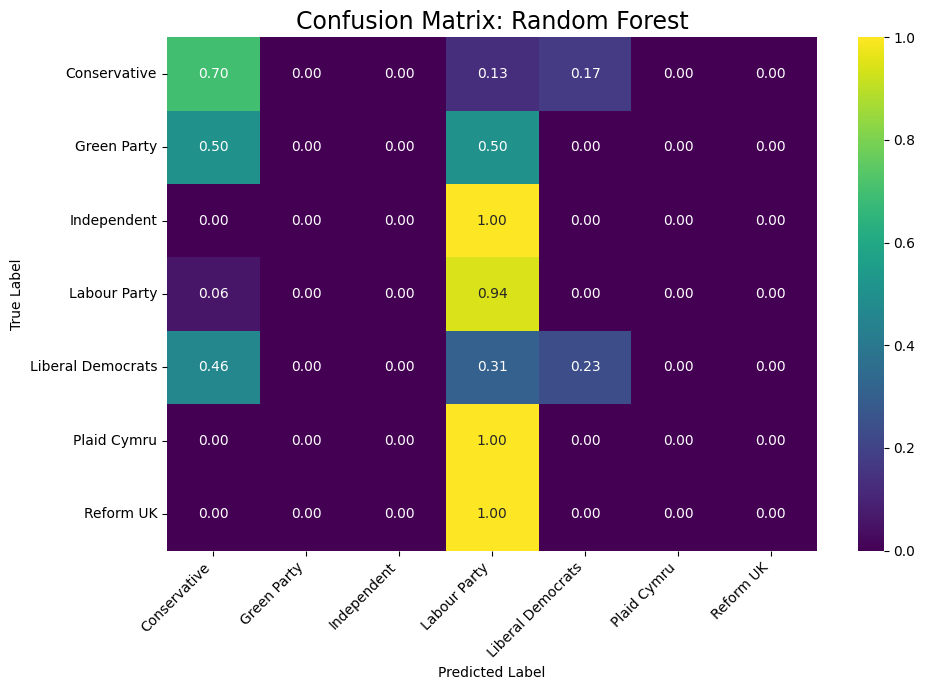

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm_rf = confusion_matrix(y_test, y_pred, normalize='true')
classes = ['Conservative', 'Green Party', 'Independent', 'Labour Party', 
           'Liberal Democrats', 'Plaid Cymru', 'Reform UK']

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))  
sns.heatmap(cm_rf, annot=True, fmt=".2f", cmap="viridis", xticklabels=classes, yticklabels=classes)


plt.xticks(rotation=45, ha='right')  
plt.yticks(rotation=0)              
plt.xlabel('Predicted Label', fontsize=10)
plt.ylabel('True Label', fontsize=10)
plt.title('Confusion Matrix: Random Forest', fontsize=17)                   
plt.tight_layout()                   
plt.show()

#code source: (Law et al., 2024d; OpenAI, 2024m)

#### 5.1.3 GridSearchCV: Random Forest
I used GridSearchCV to tune the model, and the resulting best parameters for the Random Forest were: `{'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 75}`. The out-of-sample test accuracy for the tuned RandomForestClassifier was 0.739, which is lower than the base model. This outcome may be attributed to the use of the balanced accuracy metric, which provides a more realistic evaluation of the model's performance on imbalanced datasets by accounting for both majority and minority classes more equitably. This is further evident from the tuned classification report and confusion matrix.

In [18]:
from sklearn.model_selection import GridSearchCV# Create the parameter grid based on the results of random search 
param_grid = {
    'n_estimators': [50, 75, 100],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4] 
}
# Create a based model
model = RandomForestClassifier(random_state=42)# Instantiate the grid search model
grid_search_rf = GridSearchCV(estimator = model, param_grid = param_grid, 
                          cv = 5 # number of folds for cross validation
                           , n_jobs = -1 # use all processors
                            , verbose = 2 # what to display
                              ,  scoring='accuracy'
                          )
grid_search_rf.fit(X_train_final, y_train)
model = grid_search_rf.best_estimator_
y_pred_forest_tuned=model.predict(X_test_final)
print("Best parameters for Random Forest:", grid_search_rf.best_params_)
print ('the out of sample test accuracy for a RandomForestClassifier is : '+ str(round(accuracy_score(y_test, y_pred_forest_tuned),3)))

train_accuracy = model_forest.score(X_train_final, y_train)

#code source: (Law et al., 2024d; OpenAI, 2024q)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


C:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best parameters for Random Forest: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 75}
the out of sample test accuracy for a RandomForestClassifier is : 0.739


#### 5.1.4 Classification Report: Tuned Random Forest

In [19]:
print("Tuned Random Forest:\n", classification_report(y_test, y_pred_forest_tuned))

Tuned Random Forest:
                    precision    recall  f1-score   support

     Conservative       0.57      0.70      0.63        23
      Green Party       0.00      0.00      0.00         2
      Independent       0.00      0.00      0.00         3
     Labour Party       0.81      0.96      0.88        71
Liberal Democrats       0.33      0.08      0.12        13
      Plaid Cymru       0.00      0.00      0.00         1
        Reform UK       0.00      0.00      0.00         2

         accuracy                           0.74       115
        macro avg       0.24      0.25      0.23       115
     weighted avg       0.65      0.74      0.68       115



C:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

#### 5.1.5 Confusion Matrix: Tuned Random Forest¶

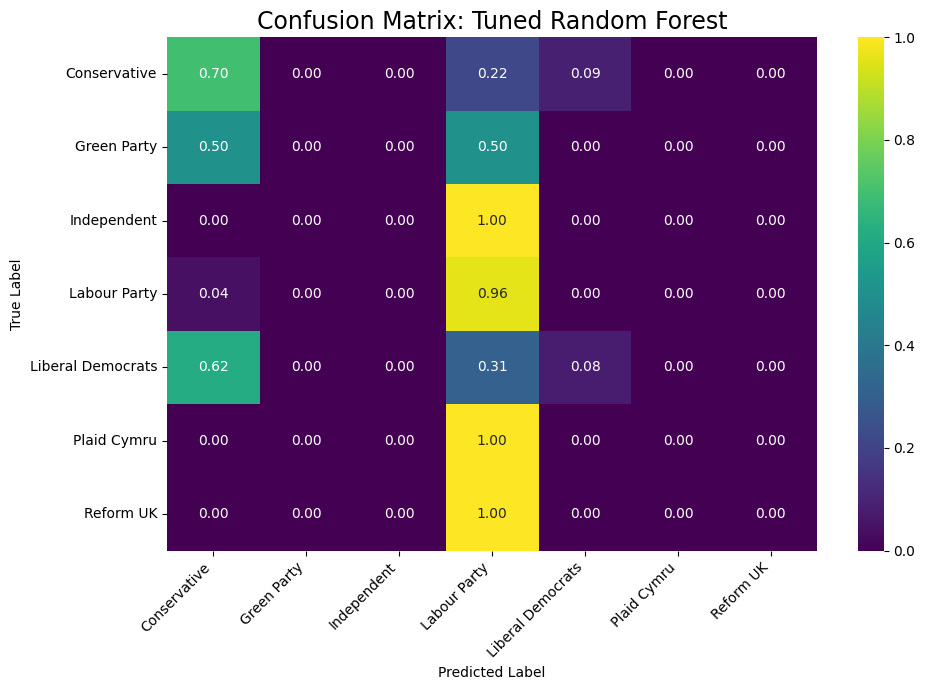

In [20]:
cm_rf_tuned = confusion_matrix(y_test, y_pred_forest_tuned, normalize='true')
classes = ['Conservative', 'Green Party', 'Independent', 'Labour Party', 
           'Liberal Democrats', 'Plaid Cymru', 'Reform UK']

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))  
sns.heatmap(cm_rf_tuned, annot=True, fmt=".2f", cmap="viridis", xticklabels=classes, yticklabels=classes)


plt.xticks(rotation=45, ha='right')  
plt.yticks(rotation=0)              
plt.xlabel('Predicted Label',fontsize=10)
plt.ylabel('True Label',fontsize=10)
plt.title('Confusion Matrix: Tuned Random Forest',fontsize=17)                   
plt.tight_layout()                   
plt.show()

#code source: (Law et al., 2024d; OpenAI, 2024m)

### 5.2 SVM
SVM model configured with kernel='linear', random_state=42, and C=1 achieved a training accuracy of 88.91% and a test accuracy of 75.65%. The relatively higher accuracy on the training set compared to the test set suggests that the SVM model may be overfitting the data, potentially due to the imbalanced nature of the dataset.  However, the SVM model appears to be less overfitted compared to the Random Forest model, as its training accuracy is not as high, indicating better generalization.

In [21]:
from sklearn.svm import SVC

#Linear SVM Classification
model_svm_linear = SVC(kernel='linear',random_state=42, C=1)
model_svm_linear.fit(X_train_final, y_train)
y_pred_svm = model_svm_linear.predict(X_test_final)

train_svm_accuracy = model_svm_linear.score(X_train_final, y_train)
test_svm_accuracy = model_svm_linear.score(X_test_final, y_test)

print(f"Training SVM Accuracy: {train_svm_accuracy}")
print(f"Test SVM Accuracy: {test_svm_accuracy}")

#code source: (Géron, 2017; OpenAI, 2024b)

Training SVM Accuracy: 0.8891304347826087
Test SVM Accuracy: 0.7565217391304347


#### 5.2.1 Classification Report: SVM
Although the accuracy is lower than that of the Random Forest model, the SVM model outperforms it in both the f1 macro average and weighted average metrics. This indicates that the SVM model performs better across both the majority and minority classes.

In [22]:
print("SVM:\n", classification_report(y_test, y_pred_svm))

SVM:
                    precision    recall  f1-score   support

     Conservative       0.58      0.65      0.61        23
      Green Party       0.00      0.00      0.00         2
      Independent       0.00      0.00      0.00         3
     Labour Party       0.86      0.92      0.88        71
Liberal Democrats       0.54      0.54      0.54        13
      Plaid Cymru       0.00      0.00      0.00         1
        Reform UK       0.00      0.00      0.00         2

         accuracy                           0.76       115
        macro avg       0.28      0.30      0.29       115
     weighted avg       0.70      0.76      0.73       115



C:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

#### 5.2.2 Confusion Matrix: SVM

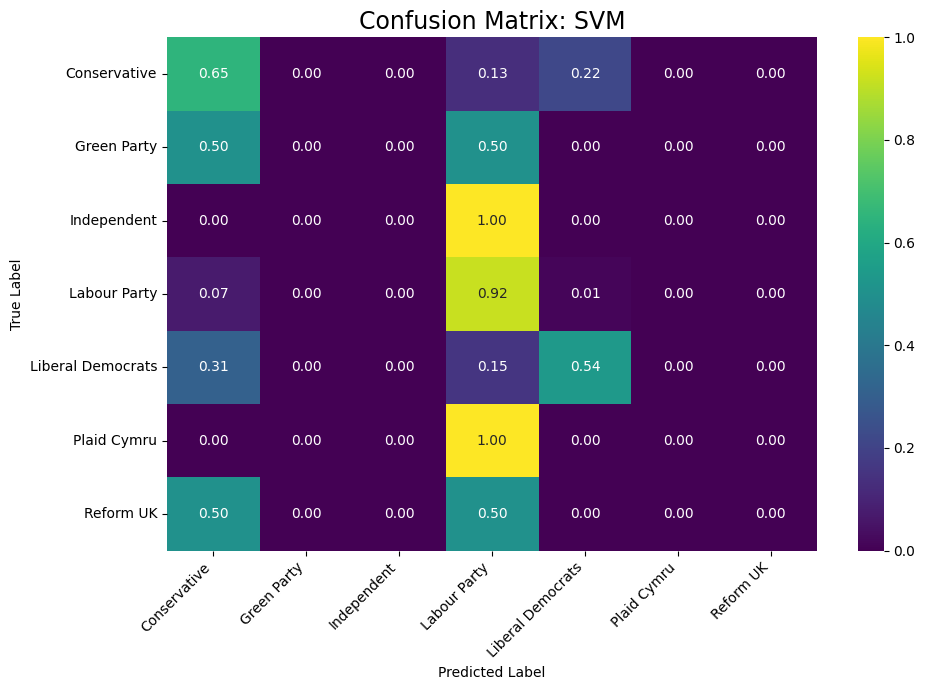

In [23]:
cm_svm = confusion_matrix(y_test, y_pred_svm, normalize='true')
classes = ['Conservative', 'Green Party', 'Independent', 'Labour Party', 
           'Liberal Democrats', 'Plaid Cymru', 'Reform UK']

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))  
sns.heatmap(cm_svm, annot=True, fmt=".2f", cmap="viridis", xticklabels=classes, yticklabels=classes)


plt.xticks(rotation=45, ha='right')  
plt.yticks(rotation=0)              
plt.xlabel('Predicted Label',fontsize=10)
plt.ylabel('True Label',fontsize=10)
plt.title('Confusion Matrix: SVM',fontsize=17)                   
plt.tight_layout()                   
plt.show()

#code source: (Law et al., 2024d; OpenAI, 2024m)

#### 5.2.3 GridSearchCV: SVM
I used GridSearchCV to tune the SVM model, and the optimal parameters found were: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}. The out-of-sample test accuracy for the tuned SVM model is 73%, which is also lower than the accuracy of the baseline model due to imbalanced data.

In [24]:
from sklearn.model_selection import GridSearchCV# Create the parameter grid based on the results of random search 
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf'], 
    'gamma': ['scale', 'auto']
}
# Create a based model
model_svm = SVC(random_state=42)
grid_search_svm = GridSearchCV(estimator = model_svm, param_grid = param_grid_svm, 
                          cv = 5 # number of folds for cross validation
                           , n_jobs = -1 # use all processors
                            , verbose = 2 # what to display
                              ,  scoring='accuracy'
                          )
grid_search_svm.fit(X_train_final, y_train)
model = grid_search_svm.best_estimator_
y_pred_svm_tuned=model.predict(X_test_final)
print("Best parameters for SVM:", grid_search_svm.best_params_)
print ('the out of sample test accuracy for a SVM is : '+ str(round(accuracy_score(y_test, y_pred_svm_tuned),3)))


#code source: (Géron, 2017; OpenAI, 2024h; OpenAI, 2024q)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


C:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best parameters for SVM: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
the out of sample test accuracy for a SVM is : 0.73


#### 5.2.4 Classification Report: Tuned SVM

In [25]:
print("Tuned SVM:\n", classification_report(y_test, y_pred_svm_tuned))

Tuned SVM:
                    precision    recall  f1-score   support

     Conservative       0.56      0.61      0.58        23
      Green Party       0.00      0.00      0.00         2
      Independent       0.00      0.00      0.00         3
     Labour Party       0.82      0.89      0.85        71
Liberal Democrats       0.54      0.54      0.54        13
      Plaid Cymru       0.00      0.00      0.00         1
        Reform UK       0.00      0.00      0.00         2

         accuracy                           0.73       115
        macro avg       0.27      0.29      0.28       115
     weighted avg       0.68      0.73      0.70       115



C:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

#### 5.2.5 Confusion Matrix: Tuned SVM

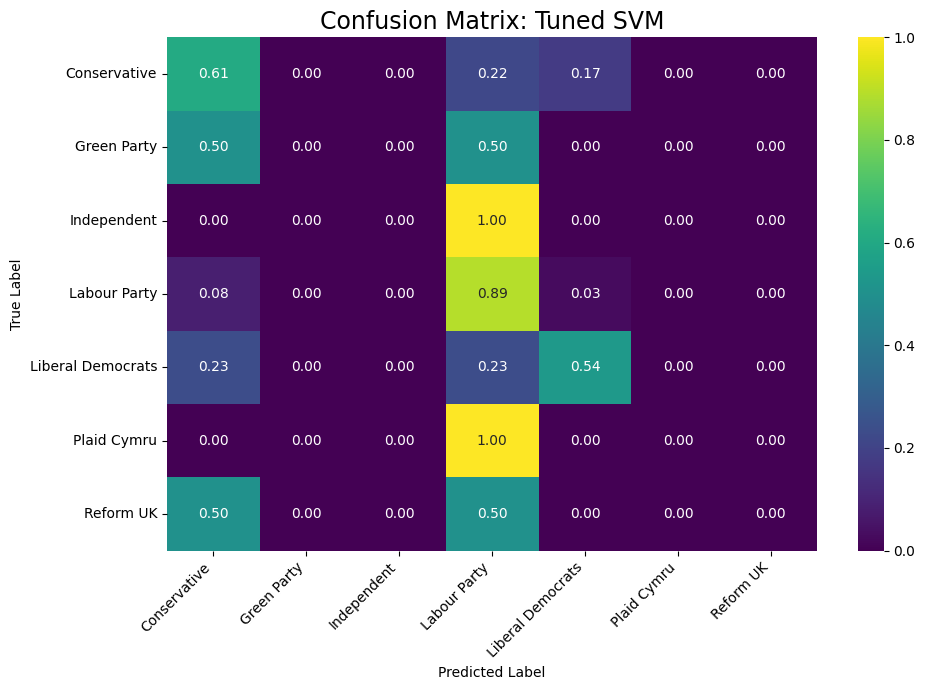

In [26]:
cm_svm_tuned = confusion_matrix(y_test, y_pred_svm_tuned, normalize='true')
classes = ['Conservative', 'Green Party', 'Independent', 'Labour Party', 
           'Liberal Democrats', 'Plaid Cymru', 'Reform UK']

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))  
sns.heatmap(cm_svm_tuned, annot=True, fmt=".2f", cmap="viridis", xticklabels=classes, yticklabels=classes)


plt.xticks(rotation=45, ha='right')  
plt.yticks(rotation=0)              
plt.xlabel('Predicted Label',fontsize=10)
plt.ylabel('True Label',fontsize=10)
plt.title('Confusion Matrix: Tuned SVM',fontsize=17)                   
plt.tight_layout()                   
plt.show()

#code source: (Law et al., 2024d; OpenAI, 2024m)

### 5.3 K-Nearest Neighbors
The KNN model achieved a training accuracy of 83.26% and a test accuracy of 71.30%, making it the least accurate among the three models. Similar to the Random Forest and SVM models, KNN shows a noticeable discrepancy between training and test accuracy, suggesting overfitting. However, the gap between the training and test accuracy is the smallest for the KNN model, indicating that it is the least prone to overfitting compared to the Random Forest and SVM models.

In [27]:
from sklearn.neighbors import KNeighborsClassifier


model_knn = KNeighborsClassifier(n_neighbors=5,weights='uniform', metric='minkowski')
model_knn.fit(X_train_final, y_train)
y_pred_knn = model_knn.predict(X_test_final)

train_accuracy = model_knn.score(X_train_final, y_train)
test_accuracy = model_knn.score(X_test_final, y_test)

print(f"Training KNN Accuracy: {train_accuracy}")
print(f"Test KNN Accuracy: {test_accuracy}")

#code source: (Law et al., 2024b; OpenAI, 2024b)

Training KNN Accuracy: 0.8326086956521739
Test KNN Accuracy: 0.7130434782608696


#### 5.3.1 Classification Report: KNN

The F1 macro average and weighted average metrics for both the SVM and Random Forest models performed better than the KNN model, indicating that the KNN model performs the worst across both the majority and minority classes.

In [28]:
print("KNN:\n", classification_report(y_test, y_pred_knn))

KNN:
                    precision    recall  f1-score   support

     Conservative       0.50      0.48      0.49        23
      Green Party       0.00      0.00      0.00         2
      Independent       0.00      0.00      0.00         3
     Labour Party       0.78      0.92      0.84        71
Liberal Democrats       0.60      0.46      0.52        13
      Plaid Cymru       0.00      0.00      0.00         1
        Reform UK       0.00      0.00      0.00         2

         accuracy                           0.71       115
        macro avg       0.27      0.27      0.26       115
     weighted avg       0.65      0.71      0.68       115



C:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

#### 5.3.2 Confusion Matrix: KNN

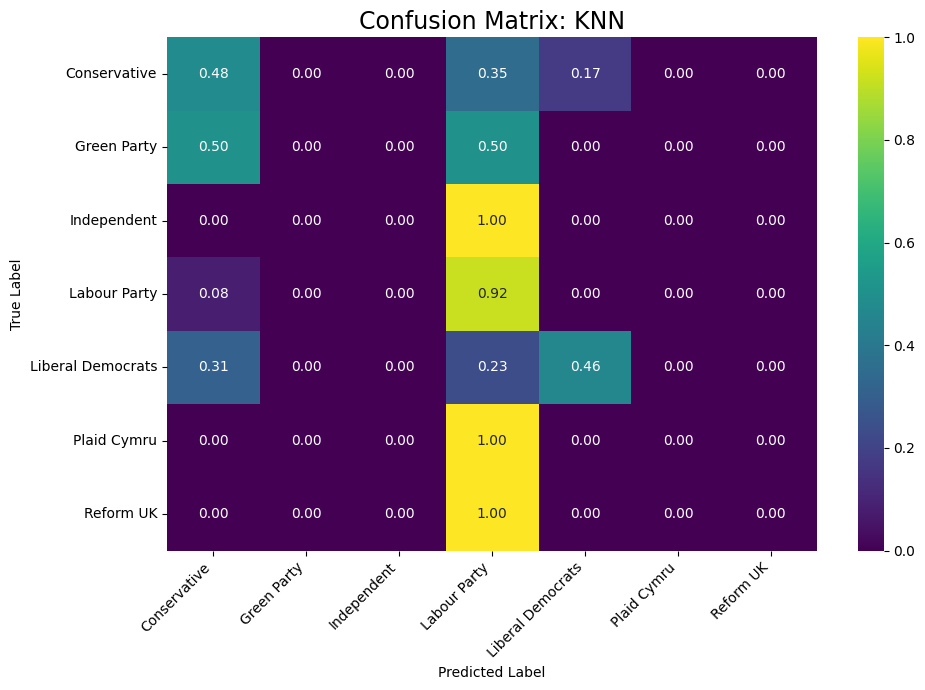

In [29]:
cm_knn = confusion_matrix(y_test, y_pred_knn, normalize='true')
classes = ['Conservative', 'Green Party', 'Independent', 'Labour Party', 
           'Liberal Democrats', 'Plaid Cymru', 'Reform UK']

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))  
sns.heatmap(cm_knn, annot=True, fmt=".2f", cmap="viridis", xticklabels=classes, yticklabels=classes)


plt.xticks(rotation=45, ha='right')  
plt.yticks(rotation=0)              
plt.xlabel('Predicted Label',fontsize=10)
plt.ylabel('True Label',fontsize=10)
plt.title('Confusion Matrix: KNN',fontsize=17)                   
plt.tight_layout()                   
plt.show()

#code source: (Law et al., 2024d; OpenAI, 2024m)

#### 5.3.3 GridSearchCV: KNN

I used GridSearchCV to tune the KNN model, and the optimal parameters were: {'metric': 'manhattan', 'n_neighbors': np.int64(19), 'weights': 'distance'}. The out-of-sample test accuracy for the tuned KNN model is 71.3%, indicating no improvement over the baseline model.

In [30]:
param_grid_knn = {
    'n_neighbors': np.arange(1, 31),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

grid_search_knn = GridSearchCV(estimator=model_knn, param_grid=param_grid_knn, 
                               cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

grid_search_knn.fit(X_train_final, y_train)
best_knn_model = grid_search_knn.best_estimator_
y_pred_knn_tuned = best_knn_model.predict(X_test_final)

print("Best parameters for KNN:", grid_search_knn.best_params_)
print('The out-of-sample test accuracy for the tuned KNN is:', 
      round(accuracy_score(y_test, y_pred_knn_tuned), 3))

#code source: (Law et al., 2024d; OpenAI, 2024q; OpenAI, 2024n)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


C:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best parameters for KNN: {'metric': 'manhattan', 'n_neighbors': np.int64(19), 'weights': 'distance'}
The out-of-sample test accuracy for the tuned KNN is: 0.713


#### 5.3.4 Classification Report: Tuned KNN

Furthermore, both the F1 macro average and the weighted average performed worse than the baseline model, with scores of 0.25 and 0.67, respectively.

In [31]:
print("Tuned KNN:\n", classification_report(y_test, y_pred_knn_tuned))

Tuned KNN:
                    precision    recall  f1-score   support

     Conservative       0.50      0.52      0.51        23
      Green Party       0.00      0.00      0.00         2
      Independent       0.00      0.00      0.00         3
     Labour Party       0.80      0.93      0.86        71
Liberal Democrats       0.50      0.31      0.38        13
      Plaid Cymru       0.00      0.00      0.00         1
        Reform UK       0.00      0.00      0.00         2

         accuracy                           0.71       115
        macro avg       0.26      0.25      0.25       115
     weighted avg       0.65      0.71      0.67       115



C:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

##### Confusion Matrix: Tuned KNN

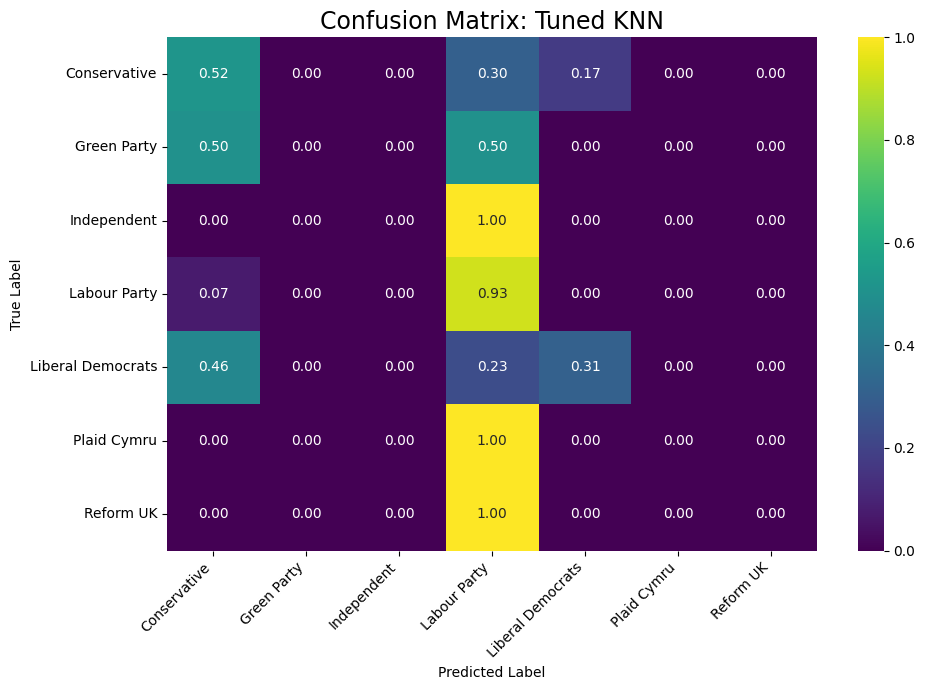

In [32]:
cm_knn_tuned = confusion_matrix(y_test, y_pred_knn_tuned, normalize='true')
classes = ['Conservative', 'Green Party', 'Independent', 'Labour Party', 
           'Liberal Democrats', 'Plaid Cymru', 'Reform UK']

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))  
sns.heatmap(cm_knn_tuned, annot=True, fmt=".2f", cmap="viridis", xticklabels=classes, yticklabels=classes)


plt.xticks(rotation=45, ha='right')  
plt.yticks(rotation=0)              
plt.xlabel('Predicted Label',fontsize=10)
plt.ylabel('True Label',fontsize=10)
plt.title('Confusion Matrix: Tuned KNN',fontsize=17)                   
plt.tight_layout()                   
plt.show()

#code source: (Law et al., 2024d; OpenAI, 2024m)

### 5.4 Graphs

#### 5.4.1 Confusion Matrix: Based Models

From the baseline models, the results are as follows: Random Forest achieved a Training Accuracy of 1.0 and Test Accuracy of 74.78%, Support Vector Machine (SVM) achieved a Training Accuracy of 88.91% and Test Accuracy of 75.65%, and K-Nearest Neighbors (KNN) achieved a Training Accuracy of 83.26% and Test Accuracy of 71.30%. Among these models, SVM showed the highest test accuracy at 75.65%.

KNN demonstrated the lowest accuracy overall but was the least overfit, with a discrepancy of approximately 12% between training and test accuracy. Conversely, Random Forest was the most overfit, with a 16% difference between training and test accuracy.

Due to the imbalanced nature of the dataset, all models tend to predict most of the labels as the Labour Party. This bias arises from the overwhelming number of constituencies where Labour secured the majority of votes. In classification problems, imbalanced datasets can negatively affect the accuracy of predictions, as the model becomes skewed toward the majority class. When additional data is available, particularly for the minority classes, it provides more information that helps the model better distinguish rare samples from the majority. Addressing this imbalance is critical for improving the model's ability to generalize across all classes.

file:///C:/Users/ACER/Downloads/Classification_of_imbalanced_data_a_review.pdf (Sun, Wong and Kamel, 2009)
https://www.researchgate.net/publication/337446604_Sampling_Approaches_for_Imbalanced_Data_Classification_Problem_in_Machine_Learning (Tyagi and Mittal, 2020)

When comparing the base models to the tuned models, all the tuned models either failed to improve or performed worse than the base models. The F1 score (macro average) and F1 score (weighted average) were also lower for the tuned models, indicating they were not effective at handling the imbalance between the minority and majority classes.

The reason the tuned model does not show improved accuracy is that, when working with imbalanced datasets and using the Grid Search method, the balanced accuracy metric provides a more realistic assessment of the model’s performance and capabilities. This metric accounts for both the majority and minority classes, which may result in lower overall accuracy but a more equitable evaluation.  

Among all the base and tuned models, the best-performing model was the base SVM, with an accuracy of 76%, an F1 score (macro average) of 29%, an F1 score (weighted average) of 73%, and a test-train accuracy discrepancy of 13%. These results suggest that the base SVM model is better suited for this imbalanced dataset compared to the other models.


file:///C:/Users/ACER/Downloads/A_comparison_of_machine_learning_methods_to_classi.pdf
https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=10757282&casa_token=k0zyyEvo5cQAAAAA:3RRbW7KXIyu_2NyhHAYLcBcBj8zJkYJiWWNiK75GADjTj9KdVj9sUrxI4XPubsh_8J2Y1n8

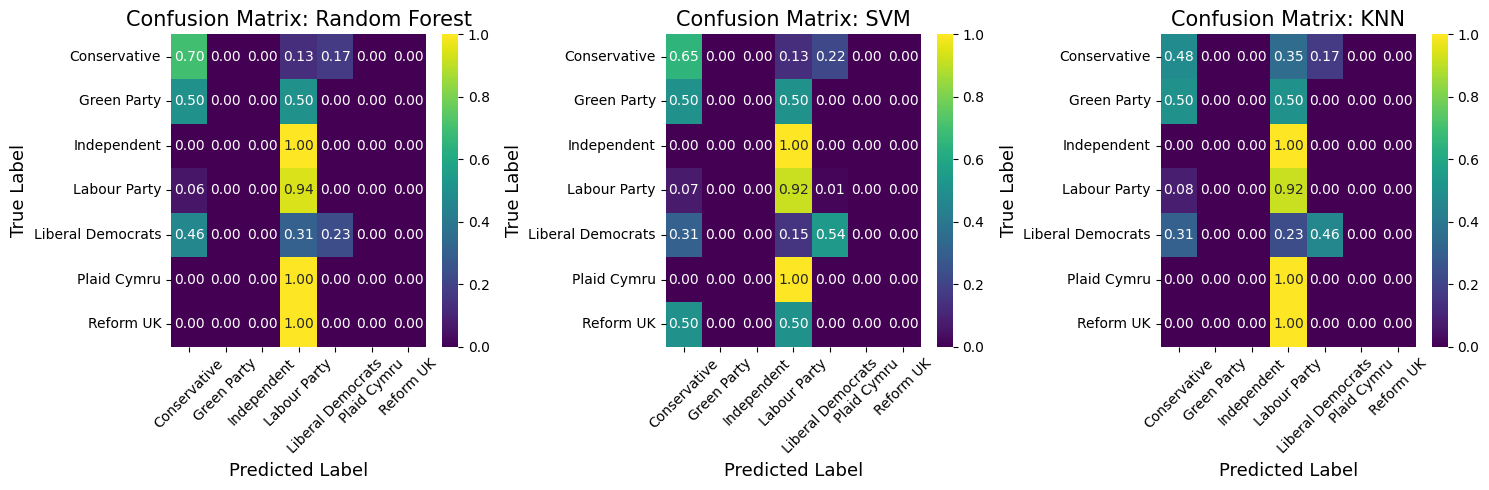

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.heatmap(cm_rf, annot=True, fmt=".2f", cmap="viridis", xticklabels=classes, yticklabels=classes, ax=axes[0])
axes[0].set_title('Confusion Matrix: Random Forest', fontsize=15)
axes[0].set_xlabel('Predicted Label', fontsize=13)
axes[0].set_ylabel('True Label', fontsize=13)
axes[0].tick_params(axis='x', rotation=45, labelsize=10)
axes[0].tick_params(axis='y', rotation=0, labelsize=10)

sns.heatmap(cm_svm, annot=True, fmt=".2f", cmap="viridis", xticklabels=classes, yticklabels=classes, ax=axes[1])
axes[1].set_title('Confusion Matrix: SVM', fontsize=15)
axes[1].set_xlabel('Predicted Label', fontsize=13)
axes[1].set_ylabel('True Label', fontsize=13)
axes[1].tick_params(axis='x', rotation=45, labelsize=10)
axes[1].tick_params(axis='y', rotation=0, labelsize=10)


sns.heatmap(cm_knn, annot=True, fmt=".2f", cmap="viridis", xticklabels=classes, yticklabels=classes, ax=axes[2])
axes[2].set_title('Confusion Matrix: KNN', fontsize=15)
axes[2].set_xlabel('Predicted Label', fontsize=13)
axes[2].set_ylabel('True Label', fontsize=13)
axes[2].tick_params(axis='x', rotation=45, labelsize=10)
axes[2].tick_params(axis='y', rotation=0, labelsize=10)

plt.tight_layout()
plt.show()

#code source: (OpenAI, 2024i)

#### 5.4.2 Confusion Matrix: Tuned Models

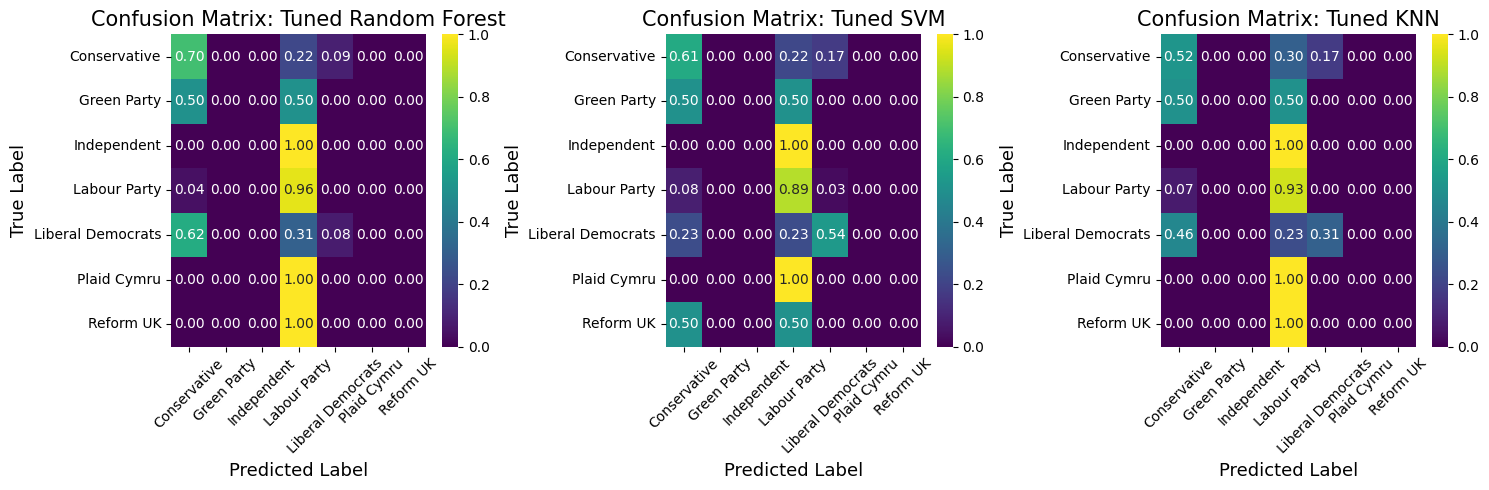

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))


sns.heatmap(cm_rf_tuned, annot=True, fmt=".2f", cmap="viridis", xticklabels=classes, yticklabels=classes, ax=axes[0])
axes[0].set_title('Confusion Matrix: Tuned Random Forest', fontsize=15)
axes[0].set_xlabel('Predicted Label', fontsize=13)
axes[0].set_ylabel('True Label', fontsize=13)
axes[0].tick_params(axis='x', rotation=45, labelsize=10)
axes[0].tick_params(axis='y', rotation=0, labelsize=10)


sns.heatmap(cm_svm_tuned, annot=True, fmt=".2f", cmap="viridis", xticklabels=classes, yticklabels=classes, ax=axes[1])
axes[1].set_title('Confusion Matrix: Tuned SVM', fontsize=15)
axes[1].set_xlabel('Predicted Label', fontsize=13)
axes[1].set_ylabel('True Label', fontsize=13)
axes[1].tick_params(axis='x', rotation=45, labelsize=10)
axes[1].tick_params(axis='y', rotation=0, labelsize=10)


sns.heatmap(cm_knn_tuned, annot=True, fmt=".2f", cmap="viridis", xticklabels=classes, yticklabels=classes, ax=axes[2])
axes[2].set_title('Confusion Matrix: Tuned KNN', fontsize=15)
axes[2].set_xlabel('Predicted Label', fontsize=13)
axes[2].set_ylabel('True Label', fontsize=13)
axes[2].tick_params(axis='x', rotation=45, labelsize=10)
axes[2].tick_params(axis='y', rotation=0, labelsize=10)


plt.tight_layout()
plt.show()

#code source: (OpenAI, 2024i)

#### 5.4.3 Feature Importances: Random Forest

                                  Feature  Importance
0                            turnout_rate    0.099419
3                        youth_population    0.088295
18                     median_house_price    0.061985
12                unemployment_claim_rate    0.061959
1                                Majority    0.061064
9                        children_poverty    0.057019
5                           Christian_pct    0.054396
20                     population_density    0.049777
10                             crime_rate    0.043983
6                            straight_pct    0.040105
17                    house_owns_mortgage    0.038537
15                       non-disabled_pct    0.036791
7                            deprived_pct    0.036667
14                  higher_qualifications    0.036418
2                         top_ad_spending    0.033733
11                        employment_rate    0.031372
4                           white_pop_pct    0.030463
8                      media

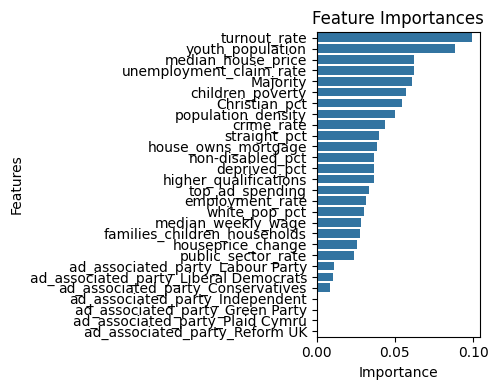

In [35]:
feature_importances = model_forest.fit(X_train_final, y_train).feature_importances_
importance_df_rf = pd.DataFrame({'Feature': X_train_final.columns, 'Importance': feature_importances})
importance_df_rf.sort_values(by='Importance', ascending=False, inplace=True)
print(importance_df_rf)

# Visualize the feature importances with Seaborn
plt.figure(figsize=(5, 4))
sns.barplot(x='Importance', y='Feature', data=importance_df_rf)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout() 
plt.show()

#code source: (Géron, 2017; Law et al., 2024d; OpenAI, 2024q; OpenAI, 2024c)

#### 5.4.4 Feature Importances: SVM

                                  Feature  Importance
19                      houseprice_change    0.583590
13                     public_sector_rate    0.540225
11                        employment_rate    0.456328
17                    house_owns_mortgage    0.437474
21      ad_associated_party_Conservatives    0.413550
24       ad_associated_party_Labour Party    0.413550
0                            turnout_rate    0.361941
16           families_children_households    0.307173
6                            straight_pct    0.298463
14                  higher_qualifications    0.289419
1                                Majority    0.273248
9                        children_poverty    0.237075
5                           Christian_pct    0.216277
3                        youth_population    0.213880
4                           white_pop_pct    0.162682
12                unemployment_claim_rate    0.120392
10                             crime_rate    0.117541
8                      media

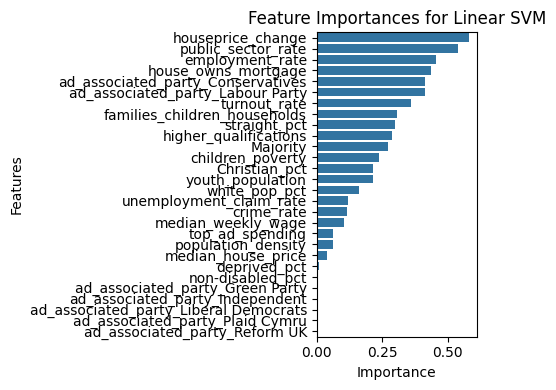

In [36]:
feature_importances = np.abs(model_svm_linear.coef_[0])
importance_df_svm = pd.DataFrame({'Feature': X_train_final.columns, 'Importance': feature_importances})
importance_df_svm.sort_values(by='Importance', ascending=False, inplace=True)

print(importance_df_svm)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 4))
sns.barplot(x='Importance', y='Feature', data=importance_df_svm)
plt.title('Feature Importances for Linear SVM')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

#code source: (OpenAI, 2024g)

#### 5.4.5 Feature Importances: KNN

                                  Feature    Importance
8                      median_weekly_wage  1.956522e-02
14                  higher_qualifications  1.913043e-02
18                     median_house_price  1.869565e-02
5                           Christian_pct  1.478261e-02
2                         top_ad_spending  1.347826e-02
1                                Majority  1.347826e-02
16           families_children_households  1.260870e-02
3                        youth_population  1.217391e-02
24       ad_associated_party_Labour Party  7.826087e-03
0                            turnout_rate  6.956522e-03
17                    house_owns_mortgage  6.086957e-03
25  ad_associated_party_Liberal Democrats  6.086957e-03
13                     public_sector_rate  5.652174e-03
4                           white_pop_pct  5.217391e-03
21      ad_associated_party_Conservatives  3.913043e-03
7                            deprived_pct  3.043478e-03
9                        children_poverty  3.043

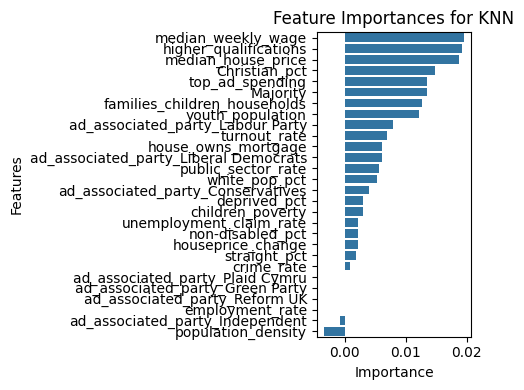

In [37]:
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(model_knn, X_train_final, y_train, scoring='accuracy')
importance_df_knn = pd.DataFrame({'Feature': X_train_final.columns, 'Importance': perm_importance.importances_mean})
importance_df_knn.sort_values(by='Importance', ascending=False, inplace=True)

print(importance_df_knn)

# Visualize the importance
plt.figure(figsize=(5, 4))
sns.barplot(x='Importance', y='Feature', data=importance_df_knn)
plt.title('Feature Importances for KNN')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

#code source: (OpenAI, 2024g)

#### 5.4.6 Feature Importances: All Models

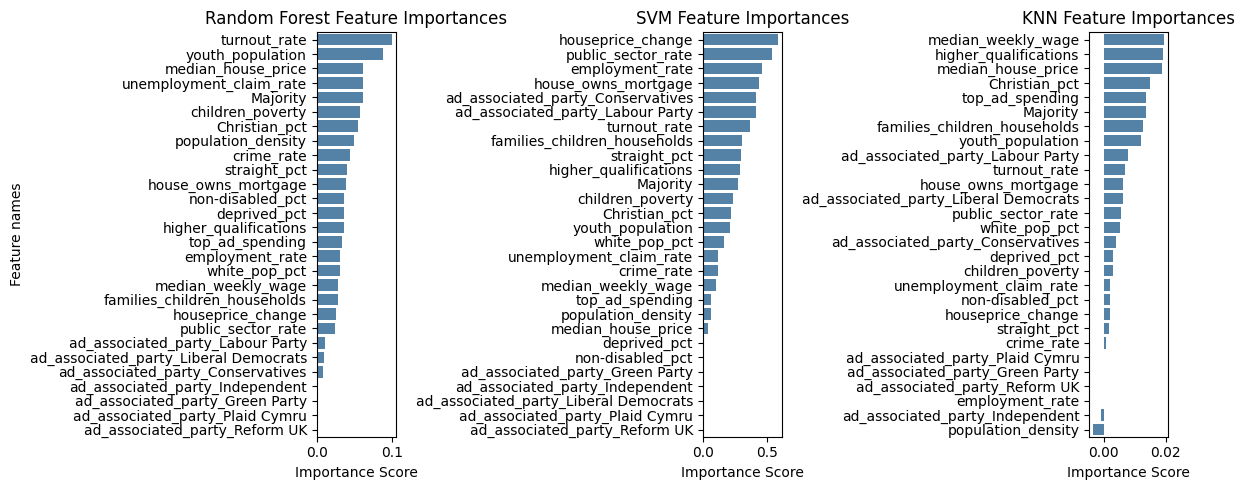

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=False)

# KNN
sns.barplot(x='Importance', y='Feature', data=importance_df_rf, ax=axes[0], color='steelblue')
axes[0].set_title('Random Forest Feature Importances', fontsize=12)
axes[0].set_xlabel('Importance Score')
axes[0].set_ylabel('Feature names')

# Random Forest
sns.barplot(x='Importance', y='Feature', data=importance_df_svm, ax=axes[1], color='steelblue')
axes[1].set_title('SVM Feature Importances', fontsize=12)
axes[1].set_xlabel('Importance Score')
axes[1].set_ylabel('') 

# SVM
sns.barplot(x='Importance', y='Feature', data=importance_df_knn, ax=axes[2], color='steelblue')
axes[2].set_title('KNN Feature Importances', fontsize=12)
axes[2].set_xlabel('Importance Score')
axes[2].set_ylabel('') 

plt.tight_layout()
plt.show()

#code source: (OpenAI, 2024k)

## 5. Appendix
In this section, I evaluated the models using a more balanced dataset. I focused on constituencies where the winning MP belonged to Labour, Conservative, or Liberal Democrats—the top three parties with the most votes in England and Wales. By limiting the dataset to these parties, the models showed significant improvement compared to when all parties were included.

For the imbalanced dataset, the models achieved an average accuracy of 73%, an F1 score macro average of 26%, and an F1 score weighted average of 73%. In contrast, with the balanced dataset, the models performed with an average accuracy of 81%, an F1 score macro average of 72%, and an F1 score weighted average of 80%. This indicates that the models handled the balance between minority and majority classes much better, as reflected by the significant improvement in F1 scores. However, some imbalance still remains, as evidenced by the limited impact of GridSearchCV on the performance of the Random Forest and SVM models.

Performance of Individual Models
Random Forest:

The base Random Forest model remains overfit, achieving 100% accuracy on the training set but only 82% on the test set (18% discrepancy).
K-Nearest Neighbors (KNN):

The base KNN model achieved a training accuracy of 86% and a test accuracy of 75% (11% discrepancy).
The tuned KNN model improved significantly, achieving 81% test accuracy and reducing the train-test discrepancy to just 5%.
Support Vector Machine (SVM):

The base SVM model is the best-performing model, achieving a test accuracy of 83%, an F1 score macro average of 77%, an F1 score weighted average of 83%, and a train-test accuracy discrepancy of only 5%. This indicates no significant overfitting.
The SVM confusion matrix for the balanced dataset shows that it only makes incorrect predictions 10% of the time on average.

From the analysis of feature importance, youth population percentage emerged as the most influential variable in determining classification outcomes. Other important variables include households with children, median wage, and high educational qualification percentages. Interestingly, SVM uniquely highlighted the significance of campaign ad spending during the week leading up to the election. This finding suggests potential areas for future research into how these variables shape election outcomes.

The primary limitation of this research is the imbalanced dataset. While limiting the dataset to the top three parties improved model performance, future research could explore alternative approaches, such as predicting party coalitions. This would allow for a more balanced dataset while still incorporating smaller parties. Other methods to address imbalances, such as oversampling minority class examples or undersampling majority classes, could also be explored.

This research only utilized a few machine learning models. Future studies could expand to include algorithms such as neural networks or XGBoost, which may better capture the complexities of the data. Additionally, the variables used in this research did not fully capture the socioeconomic conditions of all constituencies. For instance, poverty rates were based solely on child poverty rates, which may not accurately reflect overall poverty levels in constituencies with low child populations.

Future research could also explore variables that are critical topics in elections, such as migration rates and NHS waiting times, as highlighted in reports like the Ipsos General Election Campaign Tracker (July 2024). Additionally, well-established predictors of election outcomes, such as incumbency and approval ratings, should be considered to provide a more comprehensive analysis. https://mpra.ub.uni-muenchen.de/122490/1/MPRA_paper_122490.pdf 

In [39]:
overall_data2 = overall_data1[overall_data1['Elected Party'].isin(["Labour Party", "Conservative", "Liberal Democrats"])]

In [40]:
from sklearn.model_selection import train_test_split

X = overall_data2.drop(columns=['ONS region ID', 'ONS ID', 'Constituency name', 
                               'Constituency type','Elected Member First Name', 'Elected Member Surname', 'Elected Member Gender','Election Result',
                            'Country name','geometry','Elected Party','Region name'])
ylabels = overall_data2['Elected Party']

(X_train, X_test, y_train, y_test) = train_test_split(X, ylabels, train_size=0.8, random_state=42)
print (f"X_train has dim of {X_train.shape}")
print (f"y_train has dim of {y_train.shape}")
print (f"X_test has dim of {X_test.shape}")
print (f"y_test has dim of {y_test.shape}")


#code source: (Géron, 2017; Law et al., 2024d; OpenAI, 2024a)

X_train has dim of (444, 22)
y_train has dim of (444,)
X_test has dim of (112, 22)
y_test has dim of (112,)


In [41]:
numerical_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = X_train.select_dtypes(include=['object']).columns


num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_imputer, numerical_cols),
        ('cat', cat_imputer, categorical_cols)
    ]
)


X_train_imputed = preprocessor.fit_transform(X_train)
X_test_imputed = preprocessor.transform(X_test)


X_train_imputed_df = pd.DataFrame(X_train_imputed, columns=numerical_cols.append(categorical_cols))
X_test_imputed_df = pd.DataFrame(X_test_imputed, columns=numerical_cols.append(categorical_cols))

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed_df[numerical_cols])
X_test_scaled = scaler.transform(X_test_imputed_df[numerical_cols])
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=numerical_cols)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=numerical_cols)

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_encoded = encoder.fit_transform(X_train_imputed_df[categorical_cols])
X_test_encoded = encoder.transform(X_test_imputed_df[categorical_cols])
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(categorical_cols))
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(categorical_cols))

X_train_final = pd.concat([X_train_scaled_df, X_train_encoded_df], axis=1)
X_test_final = pd.concat([X_test_scaled_df, X_test_encoded_df], axis=1)

#code source: (Géron, 2017; scikit-learn, 2024; OpenAI, 2024r;  Law et al., 2024d; OpenAI, 2024p)

In [42]:
model_forest =  RandomForestClassifier(max_depth=None, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 100, random_state=42)
model_forest.fit(X_train_final, y_train)
y_pred=model_forest.predict(X_test_final)

train_accuracy = model_forest.score(X_train_final, y_train)
test_accuracy = model_forest.score(X_test_final, y_test)

print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")
print("Random Forest:\n", classification_report(y_test, y_pred))

#code source: (Law et al., 2024d; OpenAI, 2024f)

Training Accuracy: 1.0
Test Accuracy: 0.8214285714285714
Random Forest:
                    precision    recall  f1-score   support

     Conservative       0.74      0.58      0.65        24
     Labour Party       0.86      0.95      0.90        75
Liberal Democrats       0.70      0.54      0.61        13

         accuracy                           0.82       112
        macro avg       0.76      0.69      0.72       112
     weighted avg       0.81      0.82      0.81       112



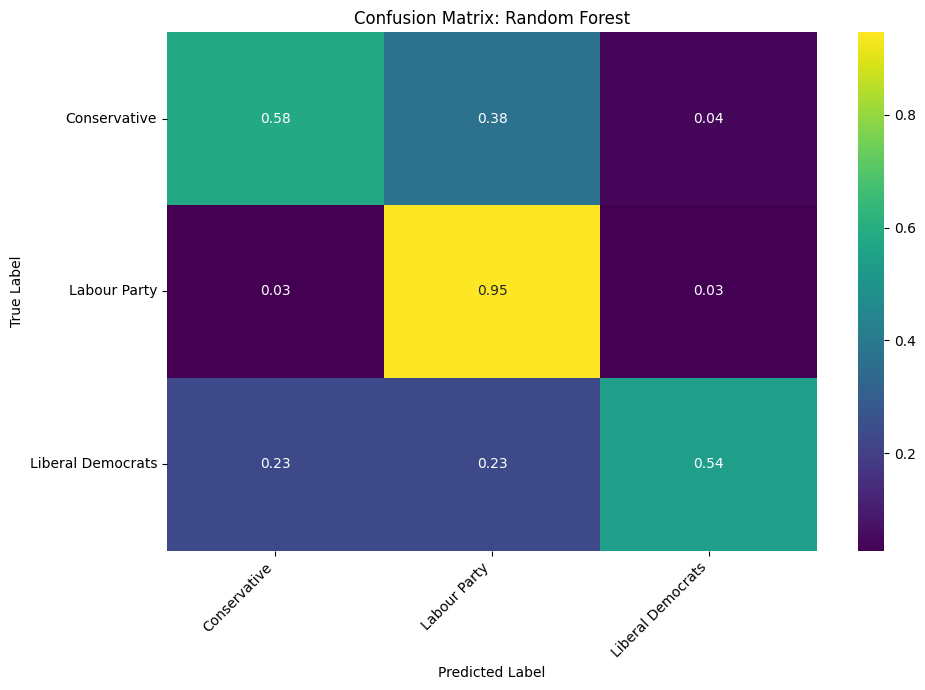

In [43]:
cm_rf_model2 = confusion_matrix(y_test, y_pred, normalize='true')
classes = ['Conservative', 'Labour Party', 
           'Liberal Democrats']

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))  
sns.heatmap(cm_rf_model2, annot=True, fmt=".2f", cmap="viridis", xticklabels=classes, yticklabels=classes)


plt.xticks(rotation=45, ha='right')  
plt.yticks(rotation=0)              
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: Random Forest')                   
plt.tight_layout()                   
plt.show()

#code source: (Law et al., 2024d; OpenAI, 2024m)

In [44]:
from sklearn.model_selection import GridSearchCV# Create the parameter grid based on the results of random search 
param_grid = {
    'n_estimators': [50, 75, 100],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4] 
}
# Create a based model
model = RandomForestClassifier(random_state=42)# Instantiate the grid search model
grid_search_rf = GridSearchCV(estimator = model, param_grid = param_grid, 
                          cv = 5 # number of folds for cross validation
                           , n_jobs = -1 # use all processors
                            , verbose = 2 # what to display
                              ,  scoring='accuracy'
                          )
grid_search_rf.fit(X_train_final, y_train)
model = grid_search_rf.best_estimator_
y_pred_forest_tuned=model.predict(X_test_final)
print("Best parameters for Random Forest:", grid_search_rf.best_params_)
print ('the out of sample test accuracy for a RandomForestClassifier is : '+ str(round(accuracy_score(y_test, y_pred_forest_tuned),3)))

#code source: (Law et al., 2024d; OpenAI, 2024q)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters for Random Forest: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
the out of sample test accuracy for a RandomForestClassifier is : 0.812


In [45]:
print("Tuned Random Forest:\n", classification_report(y_test, y_pred_forest_tuned))

Tuned Random Forest:
                    precision    recall  f1-score   support

     Conservative       0.67      0.58      0.62        24
     Labour Party       0.88      0.93      0.90        75
Liberal Democrats       0.64      0.54      0.58        13

         accuracy                           0.81       112
        macro avg       0.73      0.69      0.70       112
     weighted avg       0.80      0.81      0.81       112



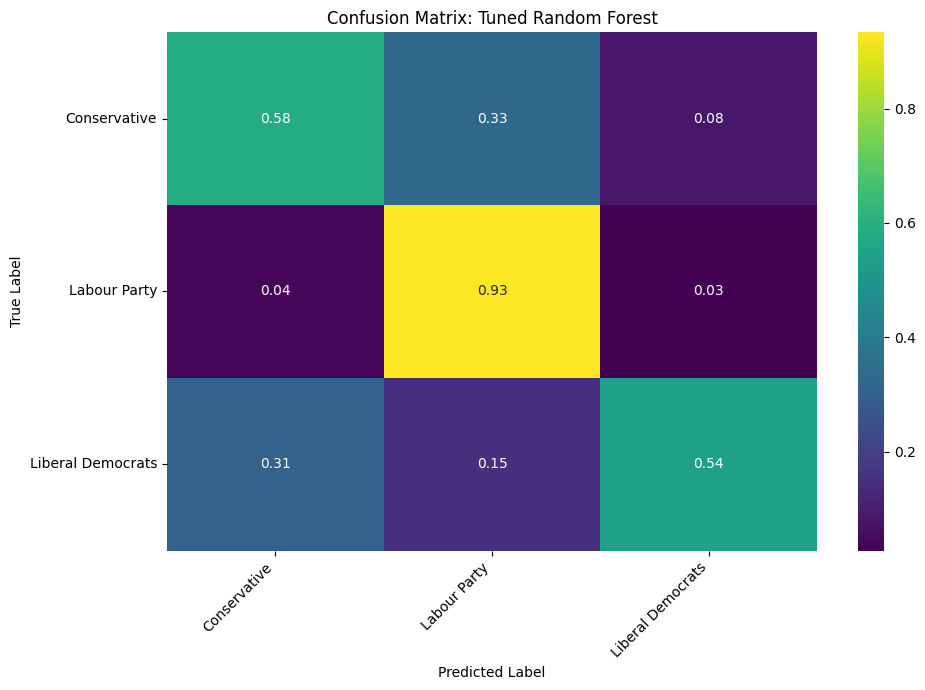

In [46]:
cm_rf_tuned_model2 = confusion_matrix(y_test, y_pred_forest_tuned, normalize='true')
classes = ['Conservative', 'Labour Party', 
           'Liberal Democrats']

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))  
sns.heatmap(cm_rf_tuned_model2, annot=True, fmt=".2f", cmap="viridis", xticklabels=classes, yticklabels=classes)


plt.xticks(rotation=45, ha='right')  
plt.yticks(rotation=0)              
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: Tuned Random Forest')                   
plt.tight_layout()                   
plt.show()

#code source: (Law et al., 2024d; OpenAI, 2024m)

#### SVM

In [47]:
from sklearn.svm import SVC

#Linear SVM Classification
model_svm_linear = SVC(kernel='linear',random_state=42, C=1)
model_svm_linear.fit(X_train_final, y_train)
y_pred_svm = model_svm_linear.predict(X_test_final)

train_svm_accuracy = model_svm_linear.score(X_train_final, y_train)
test_svm_accuracy = model_svm_linear.score(X_test_final, y_test)

print(f"Training SVM Accuracy: {train_svm_accuracy}")
print(f"Test SVM Accuracy: {test_svm_accuracy}")
print("SVM:\n", classification_report(y_test, y_pred_svm))

#code source: (Géron, 2017; OpenAI, 2024b)

Training SVM Accuracy: 0.8851351351351351
Test SVM Accuracy: 0.8303571428571429
SVM:
                    precision    recall  f1-score   support

     Conservative       0.67      0.75      0.71        24
     Labour Party       0.93      0.87      0.90        75
Liberal Democrats       0.67      0.77      0.71        13

         accuracy                           0.83       112
        macro avg       0.75      0.80      0.77       112
     weighted avg       0.84      0.83      0.83       112



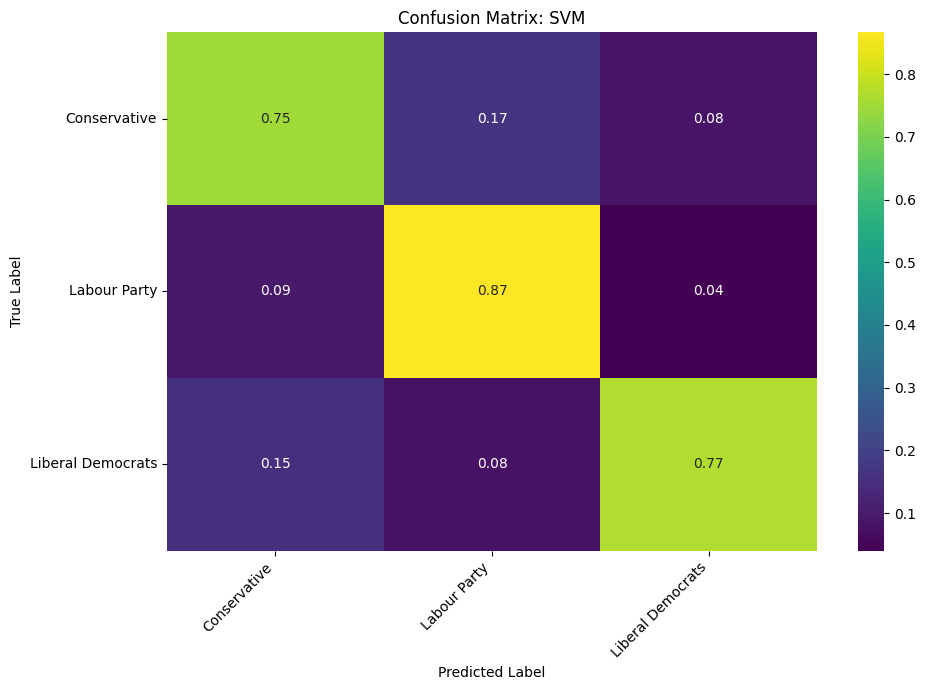

In [48]:
cm_svm_model2 = confusion_matrix(y_test, y_pred_svm, normalize='true')
classes = ['Conservative', 'Labour Party', 
           'Liberal Democrats']

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))  
sns.heatmap(cm_svm_model2, annot=True, fmt=".2f", cmap="viridis", xticklabels=classes, yticklabels=classes)


plt.xticks(rotation=45, ha='right')  
plt.yticks(rotation=0)              
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: SVM')                   
plt.tight_layout()                   
plt.show()

#code source: (Law et al., 2024d; OpenAI, 2024m)

In [49]:
from sklearn.model_selection import GridSearchCV# Create the parameter grid based on the results of random search 
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf'], 
    'gamma': ['scale', 'auto']
}
# Create a based model
model_svm = SVC(random_state=42)
grid_search_svm = GridSearchCV(estimator = model_svm, param_grid = param_grid_svm, 
                          cv = 5 # number of folds for cross validation
                           , n_jobs = -1 # use all processors
                            , verbose = 2 # what to display
                              ,  scoring='accuracy'
                          )
grid_search_svm.fit(X_train_final, y_train)
model = grid_search_svm.best_estimator_
y_pred_svm_tuned=model.predict(X_test_final)
print("Best parameters for SVM:", grid_search_svm.best_params_)
print ('the out of sample test accuracy for a SVM is : '+ str(round(accuracy_score(y_test, y_pred_svm_tuned),3)))

#code source: (Géron, 2017; OpenAI, 2024h; OpenAI, 2024q)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters for SVM: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
the out of sample test accuracy for a SVM is : 0.821


In [50]:
print("Tuned SVM:\n", classification_report(y_test, y_pred_svm_tuned))

Tuned SVM:
                    precision    recall  f1-score   support

     Conservative       0.63      0.71      0.67        24
     Labour Party       0.89      0.88      0.89        75
Liberal Democrats       0.82      0.69      0.75        13

         accuracy                           0.82       112
        macro avg       0.78      0.76      0.77       112
     weighted avg       0.83      0.82      0.82       112



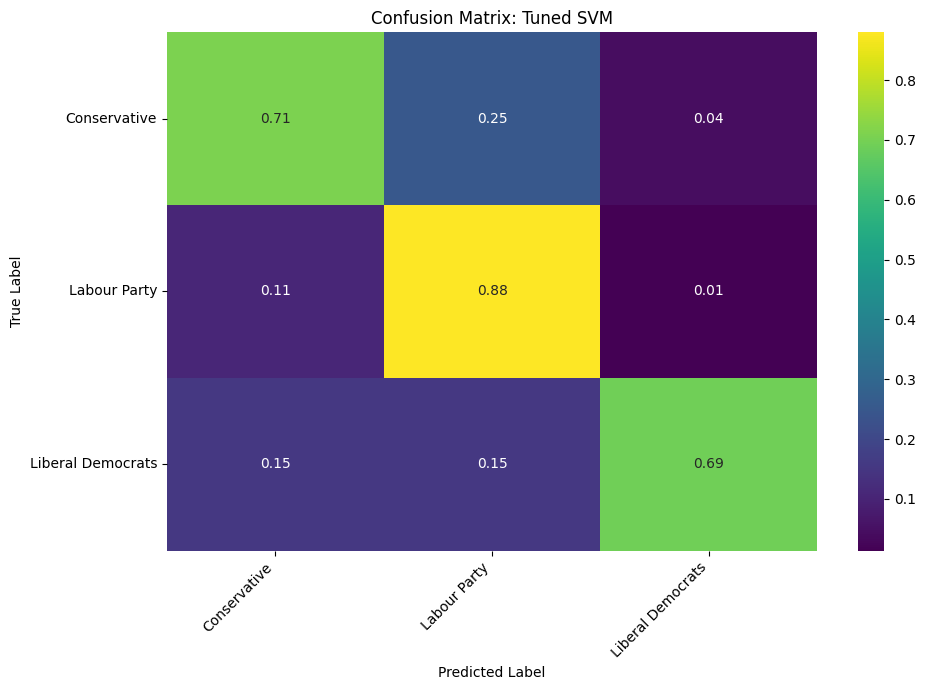

In [51]:
cm_svm_tuned_model2 = confusion_matrix(y_test, y_pred_svm_tuned, normalize='true')
classes = ['Conservative', 'Labour Party', 
           'Liberal Democrats']

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))  
sns.heatmap(cm_svm_tuned_model2, annot=True, fmt=".2f", cmap="viridis", xticklabels=classes, yticklabels=classes)


plt.xticks(rotation=45, ha='right')  
plt.yticks(rotation=0)              
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: Tuned SVM')                   
plt.tight_layout()                   
plt.show()
#code source: (Law et al., 2024d; OpenAI, 2024m)

#### KNN

In [52]:
model_knn = KNeighborsClassifier(n_neighbors=5, weights='uniform', metric='minkowski')
model_knn.fit(X_train_final, y_train)
y_pred_knn = model_knn.predict(X_test_final)

train_accuracy = model_knn.score(X_train_final, y_train)
test_accuracy = model_knn.score(X_test_final, y_test)

print(f"Training KNN Accuracy: {train_accuracy}")
print(f"Test KNN Accuracy: {test_accuracy}")
print("KNN:\n", classification_report(y_test, y_pred_knn))

#code source: (Law et al., 2024b; OpenAI, 2024b)

Training KNN Accuracy: 0.8626126126126126
Test KNN Accuracy: 0.75
KNN:
                    precision    recall  f1-score   support

     Conservative       0.59      0.54      0.57        24
     Labour Party       0.82      0.88      0.85        75
Liberal Democrats       0.50      0.38      0.43        13

         accuracy                           0.75       112
        macro avg       0.64      0.60      0.62       112
     weighted avg       0.74      0.75      0.74       112



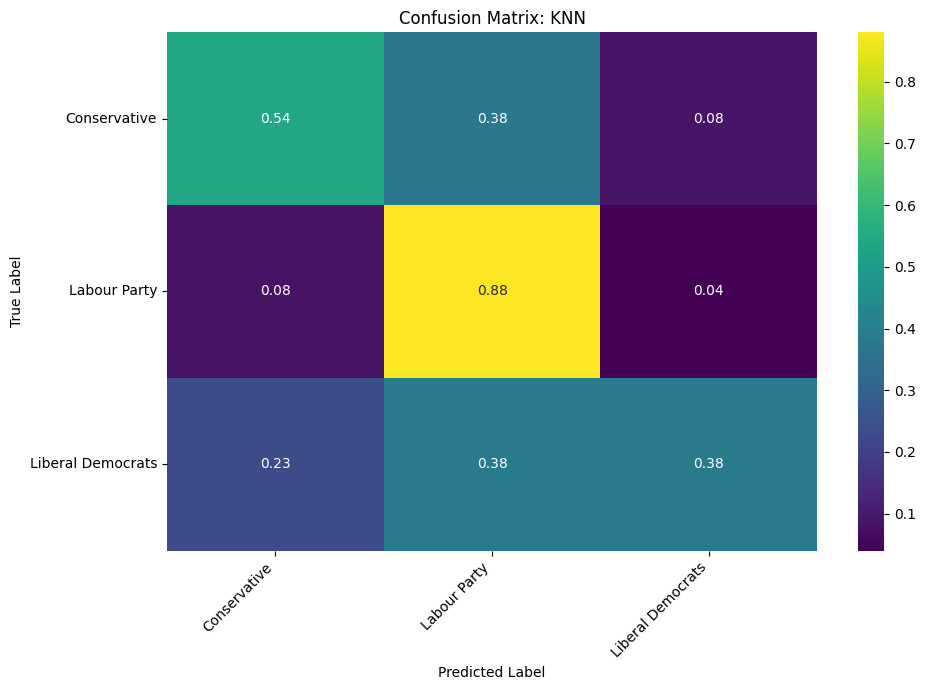

In [53]:
cm_knn_model2 = confusion_matrix(y_test, y_pred_knn, normalize='true')
classes = ['Conservative', 'Labour Party', 
           'Liberal Democrats']

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))  
sns.heatmap(cm_knn_model2 , annot=True, fmt=".2f", cmap="viridis", xticklabels=classes, yticklabels=classes)


plt.xticks(rotation=45, ha='right')  
plt.yticks(rotation=0)              
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: KNN')                   
plt.tight_layout()                   
plt.show()
#code source: (Law et al., 2024d; OpenAI, 2024m)

In [54]:
param_grid_knn = {
    'n_neighbors': np.arange(1, 31),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

grid_search_knn = GridSearchCV(estimator=model_knn, param_grid=param_grid_knn, 
                               cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

grid_search_knn.fit(X_train_final, y_train)
best_knn_model = grid_search_knn.best_estimator_
y_pred_knn_tuned = best_knn_model.predict(X_test_final)

print("Best parameters for KNN:", grid_search_knn.best_params_)
print('The out-of-sample test accuracy for the tuned KNN is:', 
      round(accuracy_score(y_test, y_pred_knn_tuned), 3))

#code source: (Law et al., 2024d; OpenAI, 2024q; OpenAI, 2024n)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best parameters for KNN: {'metric': 'euclidean', 'n_neighbors': np.int64(25), 'weights': 'distance'}
The out-of-sample test accuracy for the tuned KNN is: 0.812


In [55]:
print("Tuned KNN:\n", classification_report(y_test, y_pred_knn_tuned))

Tuned KNN:
                    precision    recall  f1-score   support

     Conservative       0.65      0.71      0.68        24
     Labour Party       0.89      0.89      0.89        75
Liberal Democrats       0.64      0.54      0.58        13

         accuracy                           0.81       112
        macro avg       0.73      0.71      0.72       112
     weighted avg       0.81      0.81      0.81       112



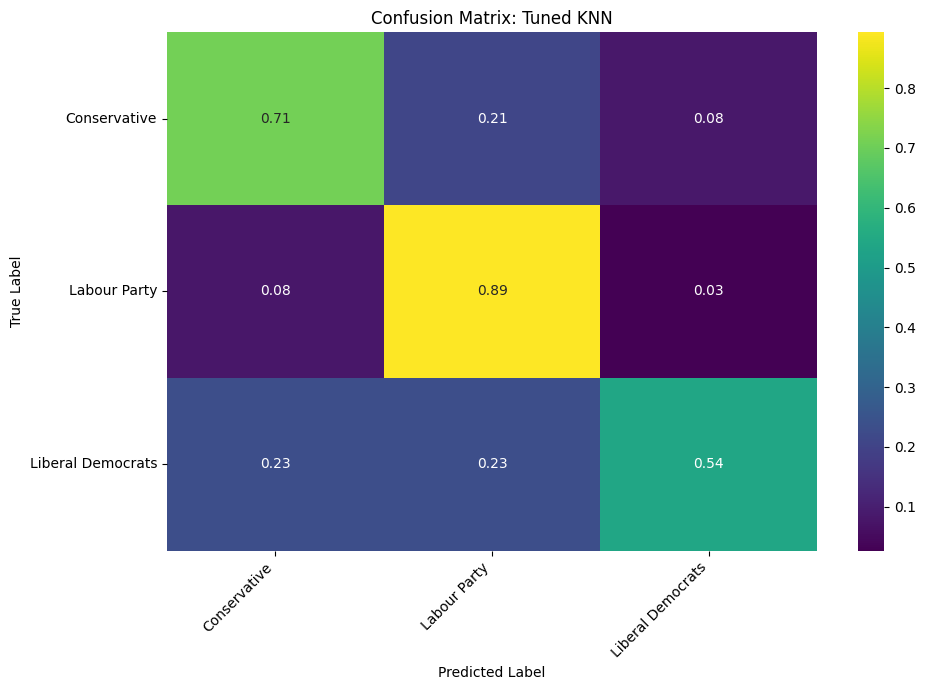

In [56]:
cm_knn_tuned_model2 = confusion_matrix(y_test, y_pred_knn_tuned, normalize='true')
classes = ['Conservative', 'Labour Party', 
           'Liberal Democrats']

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))  
sns.heatmap(cm_knn_tuned_model2, annot=True, fmt=".2f", cmap="viridis", xticklabels=classes, yticklabels=classes)


plt.xticks(rotation=45, ha='right')  
plt.yticks(rotation=0)              
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: Tuned KNN')                   
plt.tight_layout()                   
plt.show()
#code source: (Law et al., 2024d; OpenAI, 2024m)

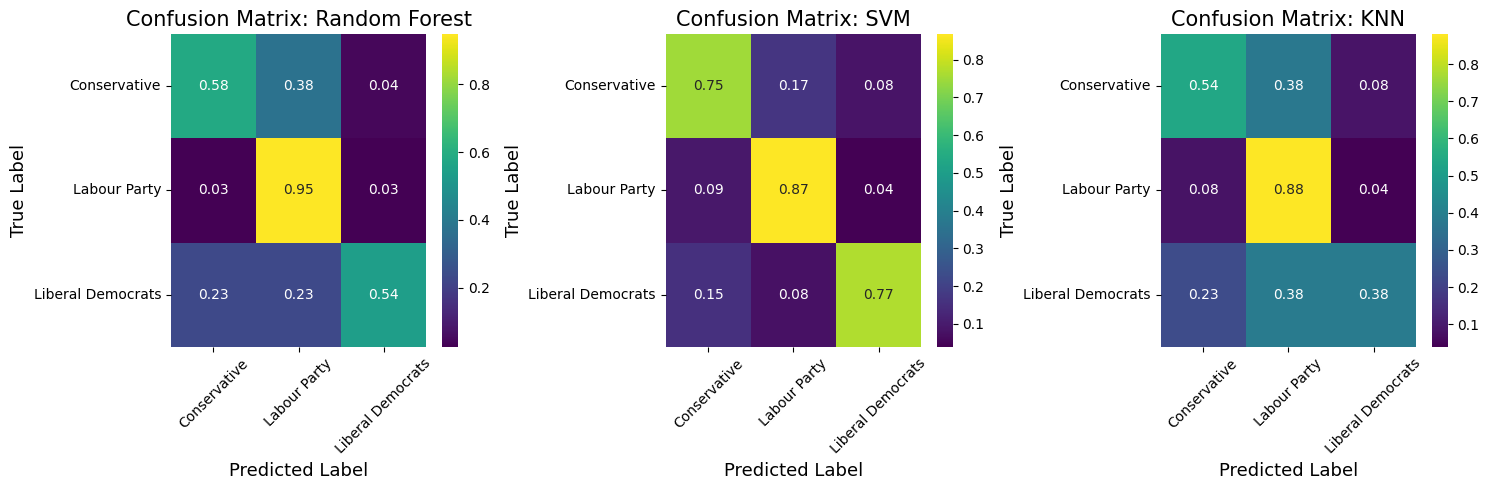

In [57]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.heatmap(cm_rf_model2, annot=True, fmt=".2f", cmap="viridis", xticklabels=classes, yticklabels=classes, ax=axes[0])
axes[0].set_title('Confusion Matrix: Random Forest', fontsize=15)
axes[0].set_xlabel('Predicted Label', fontsize=13)
axes[0].set_ylabel('True Label', fontsize=13)
axes[0].tick_params(axis='x', rotation=45, labelsize=10)
axes[0].tick_params(axis='y', rotation=0, labelsize=10)

sns.heatmap(cm_svm_model2, annot=True, fmt=".2f", cmap="viridis", xticklabels=classes, yticklabels=classes, ax=axes[1])
axes[1].set_title('Confusion Matrix: SVM', fontsize=15)
axes[1].set_xlabel('Predicted Label', fontsize=13)
axes[1].set_ylabel('True Label', fontsize=13)
axes[1].tick_params(axis='x', rotation=45, labelsize=10)
axes[1].tick_params(axis='y', rotation=0, labelsize=10)


sns.heatmap(cm_knn_model2, annot=True, fmt=".2f", cmap="viridis", xticklabels=classes, yticklabels=classes, ax=axes[2])
axes[2].set_title('Confusion Matrix: KNN', fontsize=15)
axes[2].set_xlabel('Predicted Label', fontsize=13)
axes[2].set_ylabel('True Label', fontsize=13)
axes[2].tick_params(axis='x', rotation=45, labelsize=10)
axes[2].tick_params(axis='y', rotation=0, labelsize=10)

plt.tight_layout()
plt.show()

#code source: (OpenAI, 2024i)

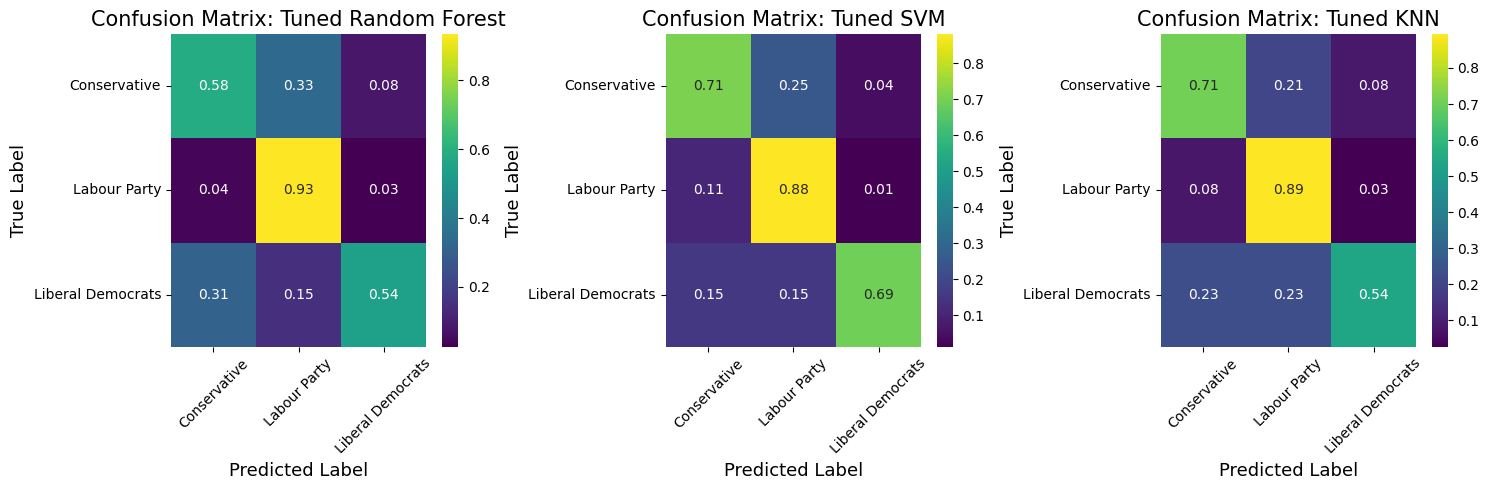

In [58]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))


sns.heatmap(cm_rf_tuned_model2, annot=True, fmt=".2f", cmap="viridis", xticklabels=classes, yticklabels=classes, ax=axes[0])
axes[0].set_title('Confusion Matrix: Tuned Random Forest', fontsize=15)
axes[0].set_xlabel('Predicted Label', fontsize=13)
axes[0].set_ylabel('True Label', fontsize=13)
axes[0].tick_params(axis='x', rotation=45, labelsize=10)
axes[0].tick_params(axis='y', rotation=0, labelsize=10)


sns.heatmap(cm_svm_tuned_model2, annot=True, fmt=".2f", cmap="viridis", xticklabels=classes, yticklabels=classes, ax=axes[1])
axes[1].set_title('Confusion Matrix: Tuned SVM', fontsize=15)
axes[1].set_xlabel('Predicted Label', fontsize=13)
axes[1].set_ylabel('True Label', fontsize=13)
axes[1].tick_params(axis='x', rotation=45, labelsize=10)
axes[1].tick_params(axis='y', rotation=0, labelsize=10)


sns.heatmap(cm_knn_tuned_model2, annot=True, fmt=".2f", cmap="viridis", xticklabels=classes, yticklabels=classes, ax=axes[2])
axes[2].set_title('Confusion Matrix: Tuned KNN', fontsize=15)
axes[2].set_xlabel('Predicted Label', fontsize=13)
axes[2].set_ylabel('True Label', fontsize=13)
axes[2].tick_params(axis='x', rotation=45, labelsize=10)
axes[2].tick_params(axis='y', rotation=0, labelsize=10)


plt.tight_layout()
plt.show()
#code source: (OpenAI, 2024i)

In [59]:
feature_importances = model_forest.fit(X_train_final, y_train).feature_importances_
importance_df_rf = pd.DataFrame({'Feature': X_train_final.columns, 'Importance': feature_importances})
importance_df_rf.sort_values(by='Importance', ascending=False, inplace=True)

feature_importances = np.abs(model_svm_linear.coef_[0])
importance_df_svm = pd.DataFrame({'Feature': X_train_final.columns, 'Importance': feature_importances})
importance_df_svm.sort_values(by='Importance', ascending=False, inplace=True)

perm_importance = permutation_importance(model_knn, X_train_final, y_train, scoring='accuracy')
importance_df_knn = pd.DataFrame({'Feature': X_train_final.columns, 'Importance': perm_importance.importances_mean})
importance_df_knn.sort_values(by='Importance', ascending=False, inplace=True)

#code source: (OpenAI, 2024c)

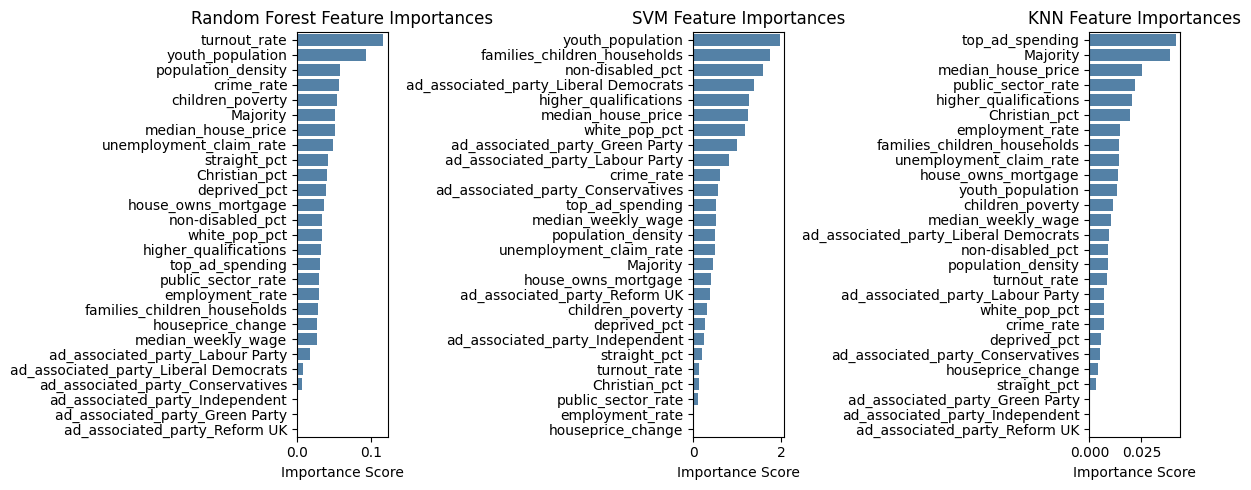

In [60]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=False)


sns.barplot(x='Importance', y='Feature', data=importance_df_rf, ax=axes[0], color='steelblue')
axes[0].set_title('Random Forest Feature Importances', fontsize=12)
axes[0].set_xlabel('Importance Score')
axes[0].set_ylabel('')


sns.barplot(x='Importance', y='Feature', data=importance_df_svm, ax=axes[1], color='steelblue')
axes[1].set_title('SVM Feature Importances', fontsize=12)
axes[1].set_xlabel('Importance Score')
axes[1].set_ylabel('') 

sns.barplot(x='Importance', y='Feature', data=importance_df_knn, ax=axes[2], color='steelblue')
axes[2].set_title('KNN Feature Importances', fontsize=12)
axes[2].set_xlabel('Importance Score')
axes[2].set_ylabel('') 

plt.tight_layout()
plt.show()

#code source: (OpenAI, 2024k)

## Reference

Cross Validated (2014). cross validation - Imputation before or after splitting into train and test? [online] Cross Validated. Available at: https://stats.stackexchange.com/questions/95083/imputation-before-or-after-splitting-into-train-and-test.

Géron, A. (2017). Hands-on machine learning with Scikit-Learn and TensorFlow concepts, tools, and techniques to build intelligent systems. O’Reilly Media, Inc.

Law, S., Iliev, M., Neira, M., Tanu, N. and Keel, T. (2024a). Computer Lab 4. [online] GEOG0115-Introduction to Social and Geographic Data Science. Available at: http://localhost:8888/notebooks/GEOG00115%20-%20Lab4-Questions.ipynb [Accessed 26 Dec. 2024].

Law, S., Iliev, M., Neira, M., Tanu, N. and Keel, T. (2024b). Computer Lab 5 - Part 1. [online] GEOG0115-Introduction to Social and Geographic Data Science. Available at: http://localhost:8888/notebooks/GEOG00115%20-%20week%205%20part1%20(Questions).ipynb [Accessed 26 Dec. 2024].

Law, S., Iliev, M., Neira, M., Tanu, N. and Keel, T. (2024c). Computer Lab 6. [online] GEOG0115-Introduction to Social and Geographic Data Science. Available at: http://localhost:8888/notebooks/GEOG00115%20-%20Week%206%20Final%20(Questions).ipynb [Accessed 26 Dec. 2024].'

Law, S., Iliev, M., Neira, M., Tanu, N. and Keel, T. (2024d). GEOG0115 Computer Lab Week 7: Mining Social and Geographic Datasets. [online] GEOG0115-Introduction to Social and Geographic Data Science. Available at: http://localhost:8888/notebooks/GEOG0115_Lab7%20ML%20for%20Travel%20mode%20prediction%20(Questions).ipynb [Accessed 28 Dec. 2024].

Mathew, J., Kshirsagar, R., Abidin, D.Z., Grin, J., Kanarachos, S., James, J., Alamaniotis , M. and Fitzpatrick, M. (2023). A comparison of machine learning methods to classify radioactive elements using prompt-gammaray neutron activation data. Research Square.

OpenAI (2024a). can you do machine learning analysis with correct steps from these variables ‘0 ONS ID 575 non-null object’. [online] ChatGPT (December 29, 2024 Version). Available at: https://chatgpt.com/c/67732696-a768-800a-91c4-ad0123101605 [Accessed 29 Dec. 2024].

OpenAI (2024b). can you give me code like this "from sklearn.ensemble import RandomForestClassifier from sklearn.metrics import accuracy_score model_forest = RandomForestClassifier(random_state=42) model_forest.fit(X_train_final, y_train) y_pred=model_forest.predict(X_test_final) print ('the out of sample test accuracy for a RandomForestClassifier is : '+ str(round(accuracy_score(y_test, y_pred),3)))" but for SVM and KNN. [online] ChatGPT (December 30, 2024 Version). Available at: https://chatgpt.com/c/67732696-a768-800a-91c4-ad0123101605 [Accessed 30 Dec. 2024].

OpenAI (2024c). from this code "feature_importances = model_forest.fit(X_train_final, y_train).feature_importances_ importance_df = pd.DataFrame({‘Feature’: X_train_final.columns, ‘Importance’: feature_importances}) importance_df.sort_values(by=‘Importance’, ascending=False, inplace=True) print(importance_df)", how can i USE ‘sns.barplot(x=“importance”,y=“features”,data=coef,) plt.show()’. [online] ChatGPT (December 31, 2024 Version). Available at: https://chatgpt.com/c/67732696-a768-800a-91c4-ad0123101605 [Accessed 31 Dec. 2024].

OpenAI (2024d). how to can I create multiple chloropeth maps with all the numerical columns in overall_data . [online] ChatGPT (December 27, 2024 Version). Available at: https://chatgpt.com/c/67780692-7470-800a-bec4-f3f0de820b31 [Accessed 27 Dec. 2024].

OpenAI (2024e). how to change columns Top spending page amount from object to page float64. [online] ChatGPT (December 29, 2024 Version). Available at: https://chatgpt.com/c/67732696-a768-800a-91c4-ad0123101605 [Accessed 29 Dec. 2024].

OpenAI (2024f). how to check if my model has Low bias and variance where the error in train and test sets are similar. [online] ChatGPT (December 28, 2024 Version). Available at: https://chatgpt.com/c/67732696-a768-800a-91c4-ad0123101605 [Accessed 28 Dec. 2024].

OpenAI (2024g). How to do feature importance for SVM and KNN. [online] ChatGPT (December 30, 2024 Version). Available at: https://chatgpt.com/c/67732696-a768-800a-91c4-ad0123101605 [Accessed 30 Dec. 2024].

OpenAI (2024h). how to do gridsearch "param_grid = {‘n_estimators’: [50, 75, 100], ‘max_depth’. [online] ChatGPT (December 31, 2024 Version). Available at: https://chatgpt.com/c/67732696-a768-800a-91c4-ad0123101605 [Accessed 31 Dec. 2024].

OpenAI (2024i). how to feature importance such as this. This is my code feature_importances = model_forest.fit(X_train_final, y_train).feature_importances_ importance_df = pd.DataFrame({‘Feature’: X_train_final.columns, ‘Importance’: feature_importances}) importance_df.sort_values(by=‘Importance’, ascending=False, inplace=True) print(importance_df). [online] ChatGPT (December 30, 2024 Version). Available at: https://chatgpt.com/c/67732696-a768-800a-91c4-ad0123101605 [Accessed 30 Dec. 2024].

OpenAI (2024j). how to make boxplots for each individual column numeric_data=overall_data1.select_dtypes(include=[np.number]) numeric_data.boxplot(vert=False,figsize=(8,8)) plt.show() make it 5x5 plots. [online] ChatGPT (December 28, 2024 Version). Available at: https://chatgpt.com/c/67732696-a768-800a-91c4-ad0123101605 [Accessed 28 Dec. 2024].

OpenAI (2024k). how to make individual figsize (5,4) but not overlap with each other "fig, axes = plt.subplots(1, 3, figsize=(5, 4), sharey=False). [online] ChatGPT (December 30, 2024 Version). Available at: https://chatgpt.com/c/67732696-a768-800a-91c4-ad0123101605 [Accessed 30 Dec. 2024].
OpenAI (2024l). how to make my geometry column all mulitpolygons. [online] ChatGPT (December 24, 2024 Version). Available at: https://chatgpt.com/c/67732696-a768-800a-91c4-ad0123101605 [Accessed 24 Dec. 2024].

OpenAI (2024m). how to make my predicted label not overlap with each other? [online] ChatGPT (December 31, 2024 Version). Available at: https://chatgpt.com/c/67732696-a768-800a-91c4-ad0123101605 [Accessed 31 Dec. 2024].

OpenAI (2024n). How to make this "param_grid_svm = {‘C’: [0.1, 1, 10, 100],‘kernel’: [‘linear’, ‘poly’, ‘rbf’], ‘gamma’: [‘scale’, ‘auto’]} # Create a based model model_svm = SVC(random_state=42) grid_search_svm = GridSearchCV(estimator = model_svm, param_grid = param_grid_svm, cv = 5 # number of folds for cross validation, n_jobs = -1 # use all processors, verbose = 2 # what to displ, scoring=‘accuracy’) grid_search_svm.fit(X_train_final, y_train) model = grid_search_svm.best_estimator_ y_pred_svm_tuned=model.predict(X_test_final) print("Best parameters for SVM:", grid_search_svm.best_params_) print ('the out of sample test accuracy for a SVM is : '+ str(round(accuracy_score(y_test, y_pred_svm_tuned),3)))" for KNN. [online] ChatGPT (December 27, 2024 Version). Available at: https://chatgpt.com/c/67732696-a768-800a-91c4-ad0123101605 [Accessed 27 Dec. 2024].

OpenAI (2024o). how to remove ‘Elected Party’ near the x axis in the graph? [online] ChatGPT (December 30, 2024 Version). Available at: https://chatgpt.com/c/67732696-a768-800a-91c4-ad0123101605 [Accessed 30 Dec. 2024].

OpenAI (2024p). I have done this "from sklearn.impute import SimpleImputer from sklearn.compose import ColumnTransformer from sklearn.model_selection import train_test_split import pandas as pd. [online] ChatGPT (December 30, 2024 Version). Available at: https://chatgpt.com/c/67732696-a768-800a-91c4-ad0123101605 [Accessed 30 Dec. 2024].

OpenAI (2024q). now can you create a comprehensive steps if i want to predict ‘elected party’ and i want to compare the prediction performance of RF, SVM KNN. [online] ChatGPT (December 30, 2024 Version). Available at: https://chatgpt.com/c/67732696-a768-800a-91c4-ad0123101605 [Accessed 30 Dec. 2024].

OpenAI (2024r). what if some of my columns have nan value? is it still suitable for SVM, KNN, RF? [online] ChatGPT (December 30, 2024 Version). Available at: https://chatgpt.com/c/67732696-a768-800a-91c4-ad0123101605 [Accessed 30 Dec. 2024].

scikit-learn (2024). 6.4. Imputation of missing values. [online] scikit-learn. Available at: https://scikit-learn.org/1.5/modules/impute.html [Accessed 23 Dec. 2024].

Stack Overflow (2020). Impute missing values with mean of column in machine learning. [online] Stack Overflow. Available at: https://stackoverflow.com/questions/60363476/impute-missing-values-with-mean-of-column-in-machine-learning.


